# Conditional Generative Adversarial Networks
Rather then just generating random samples, we can condition GAN's to some vector z by simply feeding the data, y that we wish to condition on to both the generator and discriminator. Hence, our Generator and Discriminator are now G(z,y) and D(x,y) respectively. Usually, y can be any type of additional inputs, for example, class labels.

We can see it with a probabilistic point of view. G(z,y) is modeling the distribution of our data, given z and y, that is, our data is generated with this scheme x∼G(x|z,y).

Similarly, for the Discriminator, now it tries to find discriminating label for x and xG, that are modeled with d∼D(d|x,y).

Hence, we could see that both D and G is jointly conditioned to two variable z or x and y.

Now, the objective function is given by:

$\min_G \max_D V(D, G) = \mathop{\mathbb{E}}_{x \sim p_{data}(x)} [\log D(x, y)] + \mathop{\mathbb{E}}_{z \sim p_z(z)} [\log(1 – D(G(z, y), y))]$

## AC-GAN
The main difference between the AC-GAN and a vanilla GAN is that to train the AC-GAN we need both training samples and training labels. These training labels are fed into the Generator, that will generate fake images using both the random noise, and the input label. The Discriminator also has to predict the source of the image, and in the AC-GAN scenario, it also has to predict the label of the image. This procedure is quite similar to the traditional Deep Learning method. 

ref: 
* http://cican17.com/gan-from-zero-to-hero-part-2-conditional-generation-by-gan/
* https://arxiv.org/pdf/1610.09585.pdf

In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd

Using TensorFlow backend.


Define class labels

In [2]:
# classes dictionary
label_dict = {0: 'tshirt',
             1: 'trouser',
             2: 'pullover',
             3: 'dress',
             4: 'coat',
             5: 'sandal',
             6: 'shirt',
             7: 'sneaker',
             8: 'bag',
             9: 'boot'}

In [3]:
def load_fashion_minst_data():
    # load the data
    (x_train, y_train), (_, _) = fashion_mnist.load_data()

    # expand to 3d, e.g. add channels dimension
    x_train = np.expand_dims(x_train, axis=-1)
    
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    return x_train, y_train

 
x_train, y_train = load_fashion_minst_data()
input_classes =pd.Series(y_train).nunique()
print("x_train shape: {}".format(x_train.shape))
print("y_train.shape:{}".format(y_train.shape))
print("Input classes:{}".format(input_classes))

x_train shape: (60000, 28, 28, 1)
y_train.shape:(60000,)
Input classes:10


## Base GAN Class

In [28]:
from IPython.display import SVG
from keras.layers import Concatenate, Input, Dense, Reshape, Flatten, Dropout, multiply, \
    BatchNormalization, Activation, Embedding, ZeroPadding2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot, plot_model
from matplotlib import pyplot
import numpy as np
 
class GAN():
    
    def __init__(self, in_shape=(28,28,1), n_classes=10, latent_dim=100):
        # size of the latent space
        self.in_shape = in_shape
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5) 
        
        # create the discriminator
        self.d_model = self.build_discriminator()
        
        # create the generator
        self.g_model = self.build_generator()
        
        # create the gan
        self.gan_model = self.build_gan()
       
    def build_discriminator(self):
        """define the standalone discriminator model"""
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)
        # scale up to image dimensions with linear activation
        n_nodes = self.in_shape[0] * self.in_shape[1]
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((self.in_shape[0], self.in_shape[1], 1))(li)
        # image input
        in_image = Input(shape=self.in_shape)
        # concat label as a channel
        merge = Concatenate()([in_image, li])
        # downsample
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
        fe = LeakyReLU(alpha=0.2)(fe)
        # downsample
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        # flatten feature maps
        fe = Flatten()(fe)
        # dropout
        fe = Dropout(0.4)(fe)
        # output
        out_layer = Dense(1, activation='sigmoid')(fe)
        # define model
        model = Model([in_image, in_label], out_layer)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model
    
    def build_generator(self):
        """define the standalone generator model"""
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)
        # linear multiplication
        n_nodes = 7 * 7
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((7, 7, 1))(li)
        # image generator input
        in_lat = Input(shape=(self.latent_dim,))
        # foundation for 7x7 image
        n_nodes = 128 * 7 * 7
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((7, 7, 128))(gen)
        # merge image gen and label input
        merge = Concatenate()([gen, li])
        # upsample to 14x14
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        # upsample to 28x28
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        # output
        out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
        # define model
        model = Model([in_lat, in_label], out_layer)
        return model

    def build_gan(self):
        """define the combined generator and discriminator model, for updating the generator"""
        # make weights in the discriminator not trainable
        self.d_model.trainable = False
        # get noise and label inputs from generator model
        gen_noise, gen_label = self.g_model.input
        # get image output from the generator model
        gen_output = self.g_model.output
        # connect image output and label input from generator as inputs to discriminator
        gan_output = self.d_model([gen_output, gen_label])
        # define gan model as taking noise and label and outputting a classification
        model = Model([gen_noise, gen_label], gan_output)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        return model  
    
    @staticmethod
    def plot_model(model, filename=None):
        """Plot the specified model, either to file, or return as an SVG if no filename is specified"""
        if filename is None:
            return(SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg')))
        else:
            plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
            
    def plot_generator(self, filename=None):
        """Plot the generator model, either to file, or return as an SVG if no filename is specified"""
        return(self.plot_model(self.g_model))
    
    def plot_discriminator(self, filename=None):
        """Plot the discriminator model, either to file, or return as an SVG if no filename is specified"""
        return(self.plot_model(self.d_model))
                
    def plot_gan(self, filename=None):
        """Plot the gan model, either to file, or return as an SVG if no filename is specified"""
        return(self.plot_model(self.g_model))
    
    def generate_real_samples(self, X, n_samples):
        """select real samples"""
        # choose random instances
        ix = np.random.randint(0, X.shape[0], n_samples)
        # select images and labels
        selected_X = X[ix]
        # generate 'real' class labels (1)
        y = np.ones((n_samples, 1))
        return selected_X, y
    
    def generate_latent_points(self, n_samples):
        """generate points in latent space as input for the generator"""
        # generate points in the latent space
        latent_points = np.random.randn(self.latent_dim * n_samples)
        # reshape into a batch of inputs for the network
        latent_points = latent_points.reshape(n_samples, self.latent_dim)
        return latent_points
    
    def generate_generator_prediction_samples(self, n_samples):
        """use the generator to generate n fake examples"""
        # generate points in latent space
        latent_points = self.generate_latent_points(n_samples)
        # predict outputs
        X = self.generator_prediction(latent_points)
        # create class labels
        y = np.zeros((n_samples, 1))
        return X, y
    
    def generator_prediction(self, latent_points):
        """use the generator to predict outputs for the given latent space"""
        return self.g_model.predict(latent_points)
    
    def generate_real_samples_conditioned(self, X, labels, n_samples):
        """select real samples with conditioning label"""
        # choose random instances
        ix = np.random.randint(0, X.shape[0], n_samples)
        # select images and labels
        selected_X, selected_labels = X[ix], labels[ix]
        # generate 'real' class labels (1)
        y = np.ones((n_samples, 1))
        return [selected_X, selected_labels], y
    
    def generate_latent_points_conditioned(self, n_samples):
        """generate points in latent space as input for the generator with conditioning label"""
        # generate points in the latent space
        latent_points = self.generate_latent_points(n_samples)
        # generate labels
        labels = np.random.randint(0, self.n_classes, n_samples)
        return [latent_points, labels]
    
    def generate_generator_prediction_samples_conditioned(self, n_samples):
        """use the generator to generate n fake examples with conditioning label"""
        # generate points in latent space
        latent_points, labels = self.generate_latent_points_conditioned(n_samples)
        # predict outputs
        X = self.generator_prediction_conditioned(latent_points, labels)
        # create class labels
        y = np.zeros((n_samples, 1))
        return [X, labels], y
    
    def generator_prediction_conditioned(self, latent_points, labels):
        """use the generator to predict outputs for the given latent space"""
        return self.g_model.predict([latent_points, labels])
    
    def train(self, X, labels, n_epochs=100, n_batch=128, reporting_period=10):
        """train the generator and discriminator"""
        bat_per_epo = int(X.shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        
        # for recording metrics.
        self.g_loss = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_loss_real = np.zeros((n_epochs * bat_per_epo, 1))        
        self.d_loss_fake = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_real = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_fake = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_acc_real_epochs = np.zeros((n_epochs, 1))
        self.d_acc_fake_epochs = np.zeros((n_epochs, 1))
        
        # manually enumerate epochs
        for i in range(n_epochs):
            
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # update discriminator model weights on randomly selected 'real' samples
                [X_real, labels_real], y_real = self.generate_real_samples(X, labels, half_batch)
                d_loss1, d_acc1  = self.d_model.train_on_batch([X_real, labels_real], y_real)
                
                # update discriminator model weights on generated 'fake' examples
                [X_fake, labels_fake], y_fake = self.generate_generator_prediction_samples(half_batch)
                d_loss2, d_acc2 = self.d_model.train_on_batch([X_fake, labels_fake], y_fake)
                
                # prepare points in latent space as input for the generator
                [z_input, labels_input] = self.generate_latent_points(n_batch)
                # create inverted labels for the fake samples
                y_gan = np.ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_loss = self.gan_model.train_on_batch([z_input, labels_input], y_gan)
                
                # summarize loss on this batch
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

                # record losses for later
                self.g_loss[i*bat_per_epo + j] = g_loss
                self.d_loss_real[i*bat_per_epo + j] = d_loss1
                self.d_loss_fake[i*bat_per_epo + j] = d_loss2
                self.d_acc_real[i*bat_per_epo + j] = d_acc1
                self.d_acc_fake[i*bat_per_epo + j] = d_acc2

            # save per epoch metrics 
            # evaluate discriminator on real examples
            n_samples = 100
            x_real, y_real = self.generate_real_samples(X, labels, n_samples)
            _, acc_real = self.d_model.evaluate(x_real, y_real, verbose=0)
            self.d_acc_real_epochs[i] = acc_real
            
            # evaluate discriminator on fake examples
            x_fake, y_fake = self.generate_generator_prediction_samples(n_samples)
            _, acc_fake = self.d_model.evaluate(x_fake, y_fake, verbose=0)
            self.d_acc_fake_epochs[i] = acc_fake
            
            # every reporting_period, plot out images.
            if i == 0 or (i+1) % reporting_period == 0 or (i+1) == n_epochs:
                self.summarize_performance(i+1)
                
        # save the generator model
        self.save_model()

    def summarize_performance(self, epoch):
        """generate samples and save as a plot and save the model"""
        self.plot_random_generated_images()
        
        # save the plot
        filename1 = 'generated_plot_%04d.png' % (epoch)
        pyplot.savefig(filename1)
        pyplot.close()
        
        # save the generator model
        filename2 = 'model_%04d.h5' % (epoch)
        self.g_model.save(filename2)
        print('>Saved: %s and %s' % (filename1, filename2))

    def summarize_performance_conditioned(self, epoch):
        """generate samples and save as a plot and save the model"""
        self.plot_random_generated_images_conditioned()
        
        # save the plot
        filename1 = 'generated_plot_%04d.png' % (epoch)
        pyplot.savefig(filename1)
        pyplot.close()
        
        # save the generator model
        filename2 = 'model_%04d.h5' % (epoch)
        self.g_model.save(filename2)
        print('>Saved: %s and %s' % (filename1, filename2))
        
    @staticmethod
    def grid_plot(examples, dimensions=(10, 10), figsize=(10, 10), cmap='gray_r'):
        """create a grid plot of multiple images"""
        pyplot.figure(figsize=figsize)
        for i in range(dimensions[0] * dimensions[1]):
            pyplot.subplot(dimensions[0], dimensions[1], 1 + i)
            pyplot.axis('off')
            pyplot.imshow(np.squeeze(examples[i]), interpolation='nearest', cmap=cmap)
        pyplot.tight_layout()
        pyplot.show()

    def plot_random_generated_images(self):
        """create a plot of randomly generated images (reversed grayscale)"""
        dimensions=(10, 10)
        figsize=(10, 10)
        n_samples=100
        
        X, _ = self.generate_generator_prediction_samples(n_samples)
            
        self.grid_plot(X, dimensions=dimensions, figsize=figsize)

        #filename = '%s_generated_plot_e%03d.png' % (identifier, epoch+1)
        #pyplot.savefig(filename)
        #pyplot.close()

    def plot_random_generated_images_conditioned(self):
        """create a plot of randomly generated images (reversed grayscale)"""
        dimensions=(10, 10)
        figsize=(10, 10)
        n_samples=100
        
        [X, _], _ = self.generate_generator_prediction_samples_conditioned(n_samples)
            
        self.grid_plot(X, dimensions=dimensions, figsize=figsize)

        #filename = '%s_generated_plot_e%03d.png' % (identifier, epoch+1)
        #pyplot.savefig(filename)
        #pyplot.close()
        
    def plot_training_metrics(self, figsize = (10,10)):
        fig = pyplot.figure(figsize=figsize)
        
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.plot(self.d_loss_real, label='Discriminator Loss (real)')
        pyplot.plot(self.d_loss_fake, label='Discriminator Loss (fake)')
        pyplot.plot(self.g_loss, label='Generator Loss')
        pyplot.legend(loc='upper right')
        pyplot.title('Losses')

        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.plot(self.d_acc_real, label='Discriminator Accuracy (real)')
        pyplot.plot(self.d_acc_fake, label='Discriminator Accuracy (fake)')
        pyplot.ylabel('')
        pyplot.xlabel('batch')
        pyplot.legend(loc='upper right')
        pyplot.title('Accuracies')

        pyplot.tight_layout(rect=[0, 0.00, 1, 0.95])
        fig.suptitle('GAN Per Batch Training Metrics', fontsize=24)  
        pyplot.show()
        
        # save plot to file
        # pyplot.savefig('results_baseline/plot_line_plot_loss.png')
        pyplot.close()

    def plot_discriminator_accuracies(self):
        plt.plot(self.d_acc_real_epochs)
        plt.plot(self.d_acc_fake_epochs)
        plt.title('GAN Per Epoch Discriminator Accuracy')
        plt.ylabel('')
        plt.xlabel('epoch')
        plt.legend(['Discriminator (real)', 'Discriminator (fake)'],loc='upper right')
        plt.show()
        
    def save_model(self):
        """save the model"""
        self.g_model.save('g_model.h5')
        self.d_model.save('d_model.h5')
        self.gan_model.save('gan_model.h5')
       
    def load_model(self):
        """load the model"""
        self.g_model = load_model("g_model.h5")
        self.d_model = load_model("d_model.h5")
        self.gan_model = load_model("gan_model.h5")        

## AC-Gan class

In [20]:
import numpy as np
from keras import backend
from keras.constraints import Constraint
from keras.initializers import RandomNormal
from keras.optimizers import RMSprop

class ACGAN(GAN):
  
    def build_discriminator(self):
        """Override building of the discriminator."""
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=self.in_shape)
        # downsample to 14x14
        fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        # normal
        fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        # downsample to 7x7
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        # normal
        fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        # flatten feature maps
        fe = Flatten()(fe)
        # real/fake output
        out1 = Dense(1, activation='sigmoid')(fe)
        # class label output
        out2 = Dense(self.n_classes, activation='softmax')(fe)
        # define model
        model = Model(in_image, [out1, out2])
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model
    
    def build_generator(self):
        """Override building the standalone generator model"""
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)
        # linear multiplication
        n_nodes = 7 * 7
        li = Dense(n_nodes, kernel_initializer=init)(li)
        # reshape to additional channel
        li = Reshape((7, 7, 1))(li)
        # image generator input
        in_lat = Input(shape=(self.latent_dim,))
        # foundation for 7x7 image
        n_nodes = 384 * 7 * 7
        gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
        gen = Activation('relu')(gen)
        gen = Reshape((7, 7, 384))(gen)
        # merge image gen and label input
        merge = Concatenate()([gen, li])
        # upsample to 14x14
        gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
        gen = BatchNormalization()(gen)
        gen = Activation('relu')(gen)
        # upsample to 28x28
        gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
        out_layer = Activation('tanh')(gen)
        # define model
        model = Model([in_lat, in_label], out_layer)
        return model

    def build_gan(self):
        """override defining of the combined generator and discriminator model, for updating the generator"""
        # make weights in the discriminator not trainable
        self.d_model.trainable = False
        # connect the outputs of the generator to the inputs of the discriminator
        gan_output = self.d_model(self.g_model.output)
        # define gan model as taking noise and label and outputting real/fake and label outputs
        model = Model(self.g_model.input, gan_output)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model

    def train(self, X, labels, n_epochs=100, n_batch=128, reporting_period=10, n_critic=5):
        """train the generator and discriminator"""
        bat_per_epo = int(X.shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        
        # for recording metrics.
        self.g_loss_authenticity = np.zeros((n_epochs * bat_per_epo, 1))
        self.g_loss_label = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_loss_real_authenticity = np.zeros((n_epochs * bat_per_epo, 1))        
        self.d_loss_real_label = np.zeros((n_epochs * bat_per_epo, 1))        
        self.d_loss_fake_authenticity = np.zeros((n_epochs * bat_per_epo, 1))        
        self.d_loss_fake_label = np.zeros((n_epochs * bat_per_epo, 1))        
        
        # manually enumerate epochs
        for i in range(n_epochs):
            
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # update discriminator model weights on randomly selected 'real' samples
                [X_real, labels_real], y_real = self.generate_real_samples_conditioned(X, labels, half_batch)
                _, d_loss_r_1, d_loss_r_2 = \
                    self.d_model.train_on_batch(X_real, [y_real, labels_real])
                
                # update discriminator model weights on generated 'fake' examples
                [X_fake, labels_fake], y_fake = self.generate_generator_prediction_samples_conditioned(half_batch)
                _, d_loss_f_1, d_loss_f_2 = \
                    self.d_model.train_on_batch(X_fake, [y_fake, labels_fake])
                
                # prepare points in latent space as input for the generator
                [z_input, labels_input] = self.generate_latent_points_conditioned(n_batch)
                # create inverted labels for the fake samples
                y_gan = -np.ones((n_batch, 1))
                # update the generator via the discriminator's error
                _, g_loss_1, g_loss_2 = \
                    self.gan_model.train_on_batch([z_input, labels_input], [y_gan, labels_input])
                
                # summarize loss on this batch
                print('>%d, %d/%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % 
                      (i+1, j+1, bat_per_epo, d_loss_r_1, d_loss_r_2, 
                       d_loss_f_1, d_loss_f_2, 
                       g_loss_1, g_loss_2))

                # record losses for later
                self.g_loss_authenticity[i*bat_per_epo + j] = g_loss_1
                self.g_loss_label[i*bat_per_epo + j] = g_loss_2
                self.d_loss_real_authenticity[i*bat_per_epo + j] = d_loss_r_1
                self.d_loss_real_label[i*bat_per_epo + j] = d_loss_r_2
                self.d_loss_fake_authenticity[i*bat_per_epo + j] = d_loss_f_1
                self.d_loss_fake_label[i*bat_per_epo + j] = d_loss_f_2
            
            # every reporting_period, plot out images.
            if i == 0 or (i+1) % reporting_period == 0 or (i+1) == n_epochs:
                self.summarize_performance_conditioned(i+1)
                
        # save the generator model
        self.save_model()
    
    def plot_training_metrics(self, figsize = (10,10)):
        fig = plt.figure(figsize=figsize)
        
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.plot(self.d_loss_real_authenticity, label='Discriminator Loss Authenticity (real)')
        pyplot.plot(self.d_loss_real_label, label='Discriminator Loss Label (real)')
        pyplot.plot(self.d_loss_fake_authenticity, label='Discriminator Loss Authenticity (fake)')
        pyplot.plot(self.d_loss_fake_label, label='Discriminator Loss Label (fake)')
        pyplot.plot(self.g_loss_authenticity, label='Generator Loss Authenticity')
        pyplot.plot(self.g_loss_label, label='Generator Loss Label')
        pyplot.legend(loc='upper right')
        pyplot.title('Losses')

        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.plot(self.d_acc_real, label='Discriminator Accuracy (real)')
        pyplot.plot(self.d_acc_fake, label='Discriminator Accuracy (fake)')
        pyplot.ylabel('')
        pyplot.xlabel('batch')
        pyplot.legend(loc='upper right')
        pyplot.title('Accuracies')

        pyplot.tight_layout(rect=[0, 0.00, 1, 0.95])
        fig.suptitle('GAN Per Batch Training Metrics', fontsize=24)  
        pyplot.show()
        
        # save plot to file
        # pyplot.savefig('results_baseline/plot_line_plot_loss.png')
        pyplot.close()        

## Define the model

In [21]:
X, y = load_fashion_minst_data()

print("Input shape:", X[0].shape)

fashion_acgan = ACGAN(in_shape=X[0].shape, n_classes=10, latent_dim=100)

Input shape: (28, 28, 1)


In [22]:
fashion_acgan.gan_model.metrics_names

['loss', 'model_7_loss', 'model_7_loss']

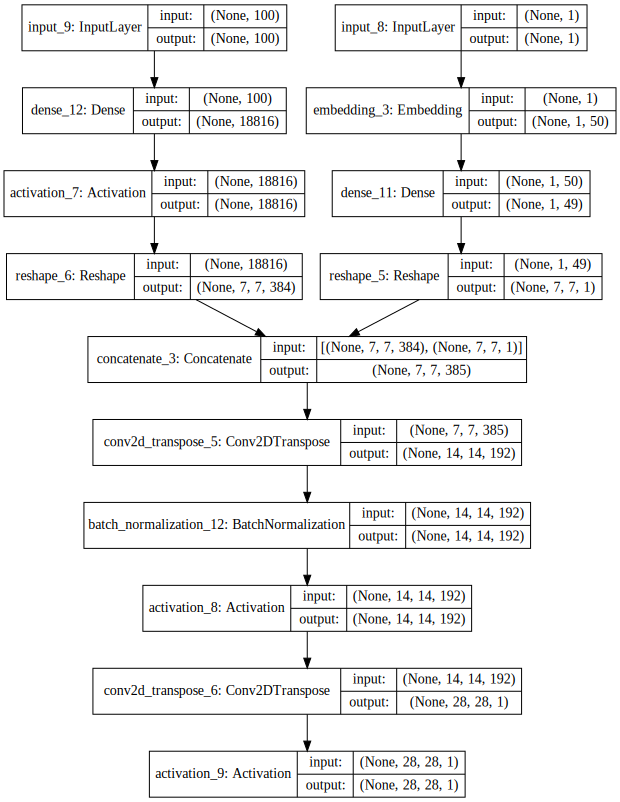

In [23]:
fashion_acgan.plot_generator()

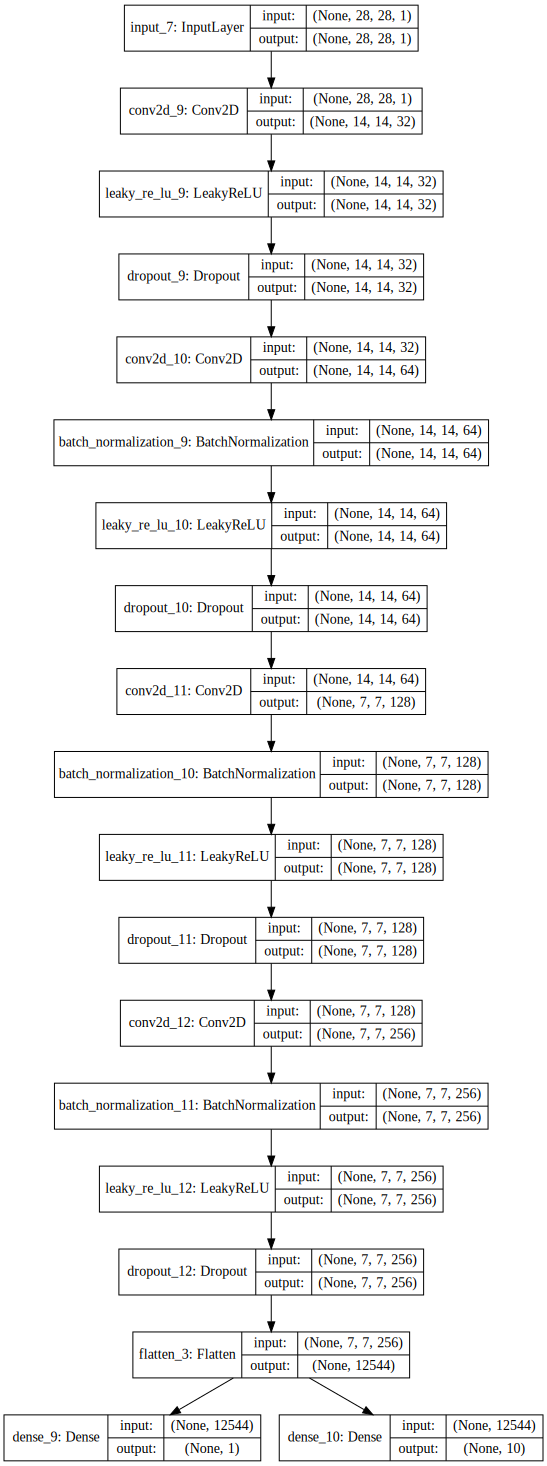

In [24]:
fashion_acgan.plot_discriminator()

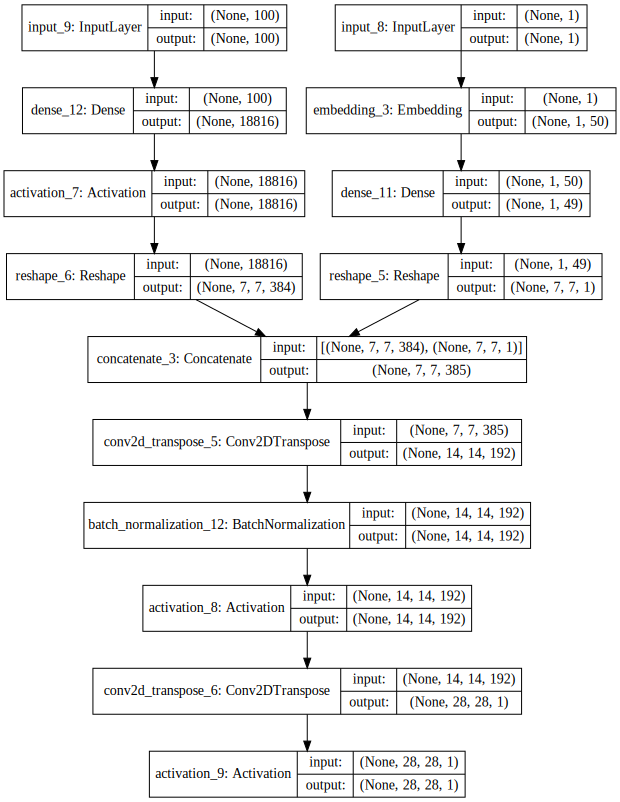

In [25]:
fashion_acgan.plot_gan()

## Train the model

C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, dr[0.592,2.916], df[1.856,2.845], g[1.849,3.190]
>1, 2/468, dr[0.396,2.820], df[1.502,2.993], g[0.969,2.976]
>1, 3/468, dr[0.668,3.419], df[0.683,3.122], g[0.285,3.111]
>1, 4/468, dr[0.614,3.176], df[0.571,3.198], g[-0.435,3.101]


C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 5/468, dr[0.564,2.612], df[0.582,2.898], g[-0.836,2.973]
>1, 6/468, dr[0.535,2.663], df[0.433,3.210], g[-0.763,3.070]
>1, 7/468, dr[0.473,2.654], df[0.474,2.993], g[-1.281,3.137]
>1, 8/468, dr[0.416,2.542], df[0.409,3.132], g[-1.769,3.146]
>1, 9/468, dr[0.354,2.612], df[0.261,3.347], g[-2.136,3.094]
>1, 10/468, dr[0.340,2.275], df[0.233,3.037], g[-2.120,2.933]
>1, 11/468, dr[0.242,2.229], df[0.179,3.083], g[-2.634,3.031]
>1, 12/468, dr[0.164,2.144], df[0.120,2.850], g[-3.038,3.229]
>1, 13/468, dr[0.158,2.120], df[0.120,2.848], g[-3.113,3.224]
>1, 14/468, dr[0.171,2.247], df[0.101,3.058], g[-3.802,2.954]
>1, 15/468, dr[0.154,2.252], df[0.102,3.030], g[-3.360,3.272]
>1, 16/468, dr[0.157,2.213], df[0.064,3.141], g[-3.904,2.902]
>1, 17/468, dr[0.142,1.785], df[0.105,3.105], g[-4.072,3.028]
>1, 18/468, dr[0.151,2.033], df[0.074,3.208], g[-4.079,2.935]
>1, 19/468, dr[0.049,1.896], df[0.057,2.938], g[-4.543,3.030]
>1, 20/468, dr[0.054,1.636], df[0.040,3.148], g[-4.639,3.177]
>1, 21/468, d

>1, 139/468, dr[0.003,1.103], df[0.001,1.888], g[-9.528,1.796]
>1, 140/468, dr[0.001,1.071], df[0.001,1.887], g[-9.420,1.813]
>1, 141/468, dr[0.003,0.580], df[0.001,1.810], g[-9.551,2.019]
>1, 142/468, dr[0.002,0.841], df[0.001,1.592], g[-9.438,1.724]
>1, 143/468, dr[0.004,0.991], df[0.001,1.742], g[-9.369,1.757]
>1, 144/468, dr[0.003,1.197], df[0.002,1.824], g[-9.654,1.718]
>1, 145/468, dr[0.002,1.080], df[0.001,1.748], g[-9.250,1.631]
>1, 146/468, dr[0.004,0.921], df[0.001,1.526], g[-9.668,1.646]
>1, 147/468, dr[0.007,0.798], df[0.001,1.531], g[-9.571,1.487]
>1, 148/468, dr[0.001,0.882], df[0.001,1.474], g[-9.507,1.448]
>1, 149/468, dr[0.001,1.010], df[0.001,1.341], g[-9.693,1.595]
>1, 150/468, dr[0.002,0.781], df[0.001,1.558], g[-9.354,1.539]
>1, 151/468, dr[0.007,1.062], df[0.001,1.364], g[-9.459,1.489]
>1, 152/468, dr[0.001,1.040], df[0.001,1.225], g[-9.521,1.216]
>1, 153/468, dr[0.001,0.704], df[0.000,1.463], g[-9.640,1.301]
>1, 154/468, dr[0.001,0.753], df[0.001,1.200], g[-9.378

>1, 271/468, dr[0.000,0.963], df[0.000,0.274], g[-9.565,0.283]
>1, 272/468, dr[0.000,0.852], df[0.000,0.304], g[-9.741,0.308]
>1, 273/468, dr[0.001,0.803], df[0.000,0.218], g[-9.538,0.244]
>1, 274/468, dr[0.003,0.819], df[0.000,0.277], g[-9.627,0.325]
>1, 275/468, dr[0.001,0.900], df[0.000,0.341], g[-9.642,0.248]
>1, 276/468, dr[0.001,0.575], df[0.000,0.379], g[-9.578,0.298]
>1, 277/468, dr[0.001,0.726], df[0.000,0.301], g[-9.667,0.470]
>1, 278/468, dr[0.002,0.557], df[0.000,0.520], g[-9.474,0.234]
>1, 279/468, dr[0.001,1.185], df[0.000,0.564], g[-9.701,0.488]
>1, 280/468, dr[0.001,1.340], df[0.000,0.334], g[-9.484,0.255]
>1, 281/468, dr[0.001,0.623], df[0.000,0.253], g[-9.770,0.329]
>1, 282/468, dr[0.001,0.616], df[0.000,0.236], g[-9.619,0.368]
>1, 283/468, dr[0.001,0.667], df[0.000,0.165], g[-9.689,0.295]
>1, 284/468, dr[0.001,0.606], df[0.000,0.188], g[-9.525,0.212]
>1, 285/468, dr[0.001,0.551], df[0.000,0.324], g[-9.912,0.390]
>1, 286/468, dr[0.001,0.932], df[0.000,0.251], g[-9.818

>1, 405/468, dr[0.001,1.243], df[0.000,0.128], g[-9.813,0.156]
>1, 406/468, dr[0.000,0.538], df[0.000,0.172], g[-9.948,0.245]
>1, 407/468, dr[0.000,0.700], df[0.000,0.239], g[-9.881,0.209]
>1, 408/468, dr[0.001,0.670], df[0.000,0.302], g[-9.869,0.199]
>1, 409/468, dr[0.000,0.377], df[0.000,0.206], g[-9.950,0.211]
>1, 410/468, dr[0.001,0.528], df[0.000,0.243], g[-9.833,0.239]
>1, 411/468, dr[0.002,0.765], df[0.000,0.143], g[-9.792,0.153]
>1, 412/468, dr[0.002,1.170], df[0.000,0.244], g[-10.004,0.210]
>1, 413/468, dr[0.001,0.630], df[0.000,0.144], g[-9.969,0.212]
>1, 414/468, dr[0.000,0.919], df[0.000,0.130], g[-9.883,0.223]
>1, 415/468, dr[0.000,1.011], df[0.000,0.179], g[-9.914,0.219]
>1, 416/468, dr[0.000,0.539], df[0.000,0.157], g[-9.979,0.274]
>1, 417/468, dr[0.002,0.696], df[0.000,0.202], g[-9.856,0.212]
>1, 418/468, dr[0.000,0.641], df[0.000,0.129], g[-9.839,0.141]
>1, 419/468, dr[0.001,0.974], df[0.000,0.186], g[-10.006,0.230]
>1, 420/468, dr[0.001,0.918], df[0.000,0.167], g[-9.8

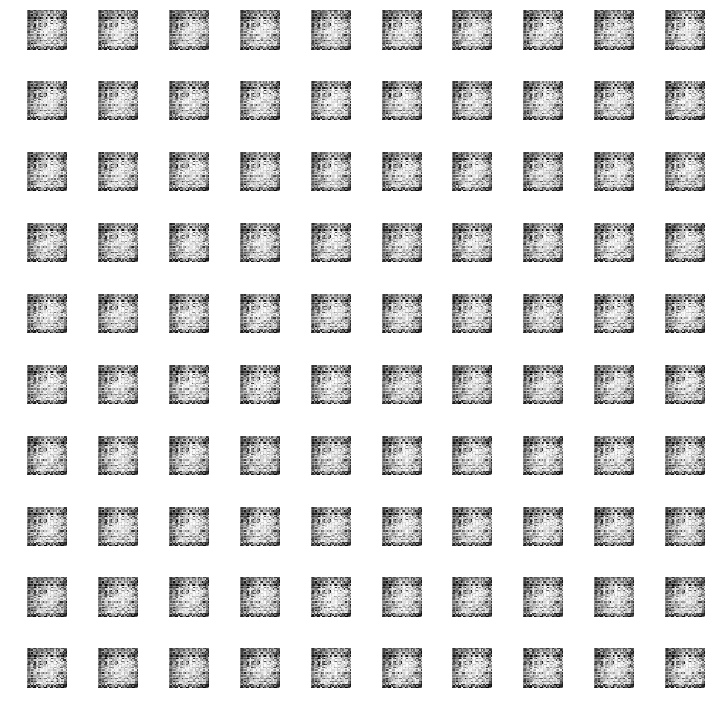

>Saved: generated_plot_0001.png and model_0001.h5
>2, 1/468, dr[0.000,0.681], df[0.000,0.199], g[-9.895,0.186]
>2, 2/468, dr[0.000,0.820], df[0.000,0.173], g[-9.943,0.159]
>2, 3/468, dr[0.001,0.633], df[0.000,0.268], g[-9.936,0.268]
>2, 4/468, dr[0.000,0.634], df[0.000,0.209], g[-9.951,0.249]
>2, 5/468, dr[0.000,1.103], df[0.000,0.180], g[-9.880,0.230]
>2, 6/468, dr[0.000,0.556], df[0.000,0.167], g[-9.955,0.283]
>2, 7/468, dr[0.000,0.938], df[0.000,0.242], g[-9.892,0.143]
>2, 8/468, dr[0.000,0.681], df[0.000,0.170], g[-9.892,0.153]
>2, 9/468, dr[0.000,0.820], df[0.000,0.170], g[-9.993,0.300]
>2, 10/468, dr[0.000,0.903], df[0.000,0.242], g[-9.975,0.159]
>2, 11/468, dr[0.001,0.675], df[0.000,0.225], g[-9.922,0.252]
>2, 12/468, dr[0.000,0.912], df[0.000,0.106], g[-9.712,0.163]
>2, 13/468, dr[0.000,0.474], df[0.000,0.150], g[-10.024,0.246]
>2, 14/468, dr[0.000,0.439], df[0.000,0.123], g[-9.947,0.310]
>2, 15/468, dr[0.000,0.742], df[0.000,0.108], g[-9.899,0.179]
>2, 16/468, dr[0.000,0.836],

>2, 135/468, dr[0.000,0.792], df[0.000,0.096], g[-10.506,0.157]
>2, 136/468, dr[0.001,0.672], df[0.000,0.191], g[-10.203,0.144]
>2, 137/468, dr[0.000,0.873], df[0.000,0.216], g[-10.398,0.325]
>2, 138/468, dr[0.000,0.786], df[0.000,0.157], g[-10.355,0.218]
>2, 139/468, dr[0.000,0.614], df[0.000,0.151], g[-10.384,0.212]
>2, 140/468, dr[0.000,0.790], df[0.000,0.080], g[-10.505,0.183]
>2, 141/468, dr[0.000,0.657], df[0.000,0.276], g[-10.415,0.137]
>2, 142/468, dr[0.000,0.709], df[0.000,0.246], g[-10.492,0.222]
>2, 143/468, dr[0.000,0.668], df[0.000,0.231], g[-10.446,0.167]
>2, 144/468, dr[0.000,0.834], df[0.000,0.247], g[-10.445,0.207]
>2, 145/468, dr[0.000,0.686], df[0.000,0.118], g[-10.298,0.148]
>2, 146/468, dr[0.000,0.665], df[0.000,0.147], g[-10.343,0.208]
>2, 147/468, dr[0.001,0.777], df[0.000,0.140], g[-10.571,0.131]
>2, 148/468, dr[0.000,0.537], df[0.000,0.101], g[-10.523,0.155]
>2, 149/468, dr[0.000,1.048], df[0.000,0.110], g[-10.380,0.137]
>2, 150/468, dr[0.000,0.617], df[0.000,0

>2, 266/468, dr[0.000,0.886], df[0.000,0.109], g[-10.647,0.223]
>2, 267/468, dr[0.000,0.707], df[0.000,0.177], g[-10.807,0.101]
>2, 268/468, dr[0.000,0.492], df[0.000,0.151], g[-10.756,0.100]
>2, 269/468, dr[0.000,0.639], df[0.000,0.174], g[-10.802,0.137]
>2, 270/468, dr[0.000,1.292], df[0.000,0.082], g[-10.706,0.200]
>2, 271/468, dr[0.002,0.700], df[0.000,0.092], g[-10.701,0.101]
>2, 272/468, dr[0.000,1.029], df[0.000,0.202], g[-10.805,0.231]
>2, 273/468, dr[0.000,0.866], df[0.000,0.098], g[-10.867,0.125]
>2, 274/468, dr[0.000,0.639], df[0.000,0.159], g[-10.548,0.149]
>2, 275/468, dr[0.000,0.786], df[0.000,0.157], g[-10.734,0.182]
>2, 276/468, dr[0.000,0.583], df[0.000,0.161], g[-10.655,0.147]
>2, 277/468, dr[0.000,1.070], df[0.000,0.134], g[-10.504,0.099]
>2, 278/468, dr[0.000,0.485], df[0.000,0.146], g[-10.642,0.158]
>2, 279/468, dr[0.000,0.705], df[0.000,0.133], g[-10.717,0.155]
>2, 280/468, dr[0.000,0.848], df[0.000,0.202], g[-10.763,0.105]
>2, 281/468, dr[0.000,0.641], df[0.000,0

>2, 399/468, dr[0.000,0.769], df[0.000,0.115], g[-10.875,0.115]
>2, 400/468, dr[0.000,0.776], df[0.000,0.203], g[-10.971,0.122]
>2, 401/468, dr[0.000,0.445], df[0.000,0.138], g[-10.972,0.216]
>2, 402/468, dr[0.000,0.564], df[0.000,0.071], g[-10.699,0.185]
>2, 403/468, dr[0.000,0.479], df[0.000,0.140], g[-10.875,0.096]
>2, 404/468, dr[0.000,0.723], df[0.000,0.198], g[-10.822,0.100]
>2, 405/468, dr[0.000,0.606], df[0.000,0.146], g[-10.886,0.149]
>2, 406/468, dr[0.000,0.540], df[0.000,0.211], g[-10.929,0.192]
>2, 407/468, dr[0.000,0.724], df[0.000,0.175], g[-10.936,0.122]
>2, 408/468, dr[0.000,0.729], df[0.000,0.160], g[-10.983,0.194]
>2, 409/468, dr[0.000,0.564], df[0.000,0.140], g[-10.830,0.195]
>2, 410/468, dr[0.000,0.435], df[0.000,0.091], g[-11.009,0.173]
>2, 411/468, dr[0.000,0.665], df[0.000,0.116], g[-10.809,0.163]
>2, 412/468, dr[0.000,0.878], df[0.000,0.068], g[-10.974,0.139]
>2, 413/468, dr[0.000,0.776], df[0.000,0.141], g[-10.850,0.160]
>2, 414/468, dr[0.000,0.782], df[0.000,0

>3, 61/468, dr[0.000,0.608], df[0.000,0.135], g[-11.029,0.186]
>3, 62/468, dr[0.000,0.427], df[0.000,0.086], g[-10.944,0.145]
>3, 63/468, dr[0.000,0.477], df[0.000,0.100], g[-11.037,0.163]
>3, 64/468, dr[0.000,0.631], df[0.000,0.260], g[-10.939,0.216]
>3, 65/468, dr[0.000,0.397], df[0.000,0.122], g[-10.813,0.126]
>3, 66/468, dr[0.000,0.383], df[0.000,0.138], g[-11.018,0.201]
>3, 67/468, dr[0.000,0.705], df[0.000,0.135], g[-10.927,0.128]
>3, 68/468, dr[0.000,0.538], df[0.000,0.069], g[-10.966,0.148]
>3, 69/468, dr[0.000,0.915], df[0.000,0.169], g[-11.010,0.151]
>3, 70/468, dr[0.000,0.690], df[0.000,0.230], g[-10.957,0.140]
>3, 71/468, dr[0.000,0.858], df[0.000,0.212], g[-10.675,0.167]
>3, 72/468, dr[0.000,0.797], df[0.000,0.140], g[-10.920,0.245]
>3, 73/468, dr[0.000,0.507], df[0.000,0.185], g[-10.977,0.129]
>3, 74/468, dr[0.000,0.515], df[0.000,0.157], g[-11.071,0.163]
>3, 75/468, dr[0.000,0.780], df[0.000,0.168], g[-11.162,0.100]
>3, 76/468, dr[0.000,0.981], df[0.000,0.109], g[-11.097

>3, 192/468, dr[0.000,0.654], df[0.000,0.150], g[-11.077,0.131]
>3, 193/468, dr[0.000,0.587], df[0.000,0.099], g[-10.881,0.145]
>3, 194/468, dr[0.000,0.478], df[0.000,0.154], g[-11.267,0.176]
>3, 195/468, dr[0.000,0.427], df[0.000,0.184], g[-11.182,0.110]
>3, 196/468, dr[0.000,0.681], df[0.000,0.143], g[-11.141,0.118]
>3, 197/468, dr[0.000,0.626], df[0.000,0.115], g[-11.170,0.113]
>3, 198/468, dr[0.000,0.697], df[0.000,0.124], g[-11.159,0.124]
>3, 199/468, dr[0.000,0.495], df[0.000,0.093], g[-11.050,0.214]
>3, 200/468, dr[0.000,0.868], df[0.000,0.108], g[-11.317,0.186]
>3, 201/468, dr[0.000,1.125], df[0.000,0.162], g[-11.388,0.137]
>3, 202/468, dr[0.000,0.810], df[0.000,0.090], g[-11.005,0.170]
>3, 203/468, dr[0.000,0.649], df[0.000,0.104], g[-11.028,0.143]
>3, 204/468, dr[0.000,0.429], df[0.000,0.075], g[-11.202,0.170]
>3, 205/468, dr[0.000,0.723], df[0.000,0.143], g[-11.127,0.183]
>3, 206/468, dr[0.000,0.611], df[0.000,0.126], g[-11.224,0.192]
>3, 207/468, dr[0.000,0.552], df[0.000,0

>3, 325/468, dr[0.000,0.682], df[0.000,0.127], g[-11.403,0.122]
>3, 326/468, dr[0.000,0.427], df[0.000,0.211], g[-11.386,0.071]
>3, 327/468, dr[0.000,0.870], df[0.000,0.101], g[-11.197,0.063]
>3, 328/468, dr[0.000,0.703], df[0.000,0.095], g[-11.439,0.149]
>3, 329/468, dr[0.000,0.813], df[0.000,0.124], g[-11.421,0.134]
>3, 330/468, dr[0.000,0.769], df[0.000,0.120], g[-11.335,0.123]
>3, 331/468, dr[0.000,0.513], df[0.000,0.122], g[-11.313,0.080]
>3, 332/468, dr[0.000,0.578], df[0.000,0.080], g[-11.385,0.214]
>3, 333/468, dr[0.000,0.777], df[0.000,0.199], g[-11.346,0.158]
>3, 334/468, dr[0.000,0.562], df[0.000,0.139], g[-11.476,0.139]
>3, 335/468, dr[0.000,0.621], df[0.000,0.269], g[-11.375,0.119]
>3, 336/468, dr[0.000,0.422], df[0.000,0.227], g[-11.331,0.143]
>3, 337/468, dr[0.000,0.343], df[0.000,0.126], g[-11.353,0.150]
>3, 338/468, dr[0.000,0.666], df[0.000,0.128], g[-11.384,0.156]
>3, 339/468, dr[0.000,1.129], df[0.000,0.107], g[-11.314,0.109]
>3, 340/468, dr[0.000,0.642], df[0.000,0

>3, 458/468, dr[0.000,0.655], df[0.000,0.137], g[-11.785,0.127]
>3, 459/468, dr[0.000,0.995], df[0.000,0.194], g[-11.814,0.120]
>3, 460/468, dr[0.000,0.820], df[0.000,0.129], g[-11.823,0.181]
>3, 461/468, dr[0.000,0.554], df[0.000,0.148], g[-11.542,0.091]
>3, 462/468, dr[0.000,0.476], df[0.000,0.107], g[-11.512,0.118]
>3, 463/468, dr[0.000,0.820], df[0.000,0.077], g[-11.641,0.170]
>3, 464/468, dr[0.000,0.608], df[0.000,0.122], g[-11.716,0.122]
>3, 465/468, dr[0.000,0.747], df[0.000,0.074], g[-11.672,0.185]
>3, 466/468, dr[0.000,0.470], df[0.000,0.086], g[-11.843,0.162]
>3, 467/468, dr[0.000,0.536], df[0.000,0.164], g[-11.723,0.157]
>3, 468/468, dr[0.000,0.427], df[0.000,0.093], g[-11.863,0.122]
>4, 1/468, dr[0.000,0.614], df[0.000,0.043], g[-11.754,0.100]
>4, 2/468, dr[0.000,0.583], df[0.000,0.048], g[-11.685,0.146]
>4, 3/468, dr[0.000,0.602], df[0.000,0.074], g[-11.444,0.136]
>4, 4/468, dr[0.000,0.676], df[0.000,0.164], g[-11.722,0.181]
>4, 5/468, dr[0.000,0.518], df[0.000,0.088], g[-

>4, 121/468, dr[0.000,0.632], df[0.000,0.105], g[-11.894,0.126]
>4, 122/468, dr[0.001,0.951], df[0.000,0.091], g[-11.806,0.166]
>4, 123/468, dr[0.000,0.537], df[0.000,0.126], g[-11.779,0.092]
>4, 124/468, dr[0.000,0.516], df[0.000,0.121], g[-11.810,0.123]
>4, 125/468, dr[0.000,0.650], df[0.000,0.088], g[-11.857,0.084]
>4, 126/468, dr[0.000,0.590], df[0.000,0.193], g[-11.940,0.187]
>4, 127/468, dr[0.000,0.685], df[0.000,0.163], g[-11.831,0.118]
>4, 128/468, dr[0.000,0.487], df[0.000,0.171], g[-11.768,0.132]
>4, 129/468, dr[0.000,0.446], df[0.000,0.134], g[-11.906,0.130]
>4, 130/468, dr[0.000,0.912], df[0.000,0.185], g[-11.812,0.104]
>4, 131/468, dr[0.000,0.442], df[0.000,0.133], g[-11.753,0.154]
>4, 132/468, dr[0.000,0.694], df[0.000,0.076], g[-11.766,0.156]
>4, 133/468, dr[0.000,0.549], df[0.000,0.121], g[-11.648,0.146]
>4, 134/468, dr[0.000,0.503], df[0.000,0.112], g[-11.924,0.079]
>4, 135/468, dr[0.000,0.395], df[0.000,0.068], g[-11.933,0.146]
>4, 136/468, dr[0.000,0.659], df[0.000,0

>4, 250/468, dr[0.000,0.723], df[0.000,0.125], g[-11.526,0.101]
>4, 251/468, dr[0.000,0.532], df[0.000,0.114], g[-11.671,0.068]
>4, 252/468, dr[0.000,0.618], df[0.000,0.154], g[-11.613,0.081]
>4, 253/468, dr[0.000,0.729], df[0.000,0.221], g[-11.680,0.081]
>4, 254/468, dr[0.000,0.572], df[0.000,0.144], g[-11.582,0.143]
>4, 255/468, dr[0.000,0.597], df[0.000,0.112], g[-11.655,0.133]
>4, 256/468, dr[0.000,0.541], df[0.000,0.050], g[-11.618,0.135]
>4, 257/468, dr[0.000,0.706], df[0.000,0.157], g[-11.541,0.177]
>4, 258/468, dr[0.000,0.605], df[0.000,0.248], g[-11.764,0.087]
>4, 259/468, dr[0.000,0.449], df[0.000,0.123], g[-11.684,0.099]
>4, 260/468, dr[0.000,0.810], df[0.000,0.103], g[-11.699,0.173]
>4, 261/468, dr[0.000,0.981], df[0.000,0.048], g[-11.632,0.156]
>4, 262/468, dr[0.000,0.406], df[0.000,0.227], g[-11.594,0.262]
>4, 263/468, dr[0.000,0.756], df[0.000,0.107], g[-11.372,0.097]
>4, 264/468, dr[0.000,0.905], df[0.000,0.204], g[-11.395,0.205]
>4, 265/468, dr[0.000,0.449], df[0.000,0

>4, 382/468, dr[0.000,0.378], df[0.000,0.230], g[-11.612,0.308]
>4, 383/468, dr[0.000,0.490], df[0.000,0.372], g[-11.308,0.308]
>4, 384/468, dr[0.000,0.344], df[0.000,0.428], g[-11.619,0.251]
>4, 385/468, dr[0.000,0.544], df[0.000,0.400], g[-11.505,0.207]
>4, 386/468, dr[0.000,0.589], df[0.000,0.197], g[-11.539,0.245]
>4, 387/468, dr[0.000,0.670], df[0.000,0.151], g[-11.637,0.245]
>4, 388/468, dr[0.000,0.341], df[0.000,0.098], g[-11.624,0.177]
>4, 389/468, dr[0.000,0.455], df[0.000,0.074], g[-11.456,0.077]
>4, 390/468, dr[0.000,0.796], df[0.000,0.118], g[-11.856,0.151]
>4, 391/468, dr[0.000,0.364], df[0.000,0.045], g[-11.790,0.087]
>4, 392/468, dr[0.000,0.565], df[0.000,0.032], g[-11.713,0.123]
>4, 393/468, dr[0.000,0.505], df[0.000,0.123], g[-11.837,0.141]
>4, 394/468, dr[0.000,0.410], df[0.000,0.119], g[-11.870,0.061]
>4, 395/468, dr[0.000,0.482], df[0.000,0.067], g[-11.894,0.084]
>4, 396/468, dr[0.000,0.659], df[0.000,0.025], g[-11.947,0.067]
>4, 397/468, dr[0.000,0.589], df[0.000,0

>5, 47/468, dr[0.000,0.850], df[0.000,0.154], g[-12.141,0.136]
>5, 48/468, dr[0.000,0.461], df[0.000,0.191], g[-11.994,0.072]
>5, 49/468, dr[0.000,0.563], df[0.000,0.079], g[-11.968,0.078]
>5, 50/468, dr[0.000,0.502], df[0.000,0.050], g[-12.177,0.090]
>5, 51/468, dr[0.000,1.054], df[0.000,0.124], g[-11.794,0.070]
>5, 52/468, dr[0.000,0.415], df[0.000,0.088], g[-11.865,0.145]
>5, 53/468, dr[0.000,0.986], df[0.000,0.146], g[-12.058,0.135]
>5, 54/468, dr[0.000,0.754], df[0.000,0.138], g[-12.229,0.131]
>5, 55/468, dr[0.000,0.459], df[0.000,0.172], g[-12.236,0.138]
>5, 56/468, dr[0.000,0.826], df[0.000,0.114], g[-12.083,0.206]
>5, 57/468, dr[0.000,0.705], df[0.000,0.173], g[-11.953,0.206]
>5, 58/468, dr[0.000,1.188], df[0.000,0.181], g[-11.959,0.163]
>5, 59/468, dr[0.000,0.361], df[0.000,0.136], g[-11.960,0.217]
>5, 60/468, dr[0.000,0.634], df[0.000,0.123], g[-12.059,0.177]
>5, 61/468, dr[0.000,0.468], df[0.000,0.119], g[-12.159,0.092]
>5, 62/468, dr[0.000,0.636], df[0.000,0.117], g[-12.034

>5, 177/468, dr[0.000,0.533], df[0.000,0.241], g[-11.991,0.118]
>5, 178/468, dr[0.000,0.912], df[0.000,0.140], g[-11.999,0.171]
>5, 179/468, dr[0.000,0.295], df[0.000,0.066], g[-12.233,0.151]
>5, 180/468, dr[0.000,0.579], df[0.000,0.111], g[-12.111,0.145]
>5, 181/468, dr[0.000,0.363], df[0.000,0.185], g[-12.133,0.161]
>5, 182/468, dr[0.000,0.423], df[0.000,0.144], g[-12.053,0.129]
>5, 183/468, dr[0.000,0.461], df[0.000,0.175], g[-12.007,0.274]
>5, 184/468, dr[0.000,0.728], df[0.000,0.275], g[-11.553,0.254]
>5, 185/468, dr[0.000,0.794], df[0.000,0.252], g[-11.888,0.193]
>5, 186/468, dr[0.000,0.678], df[0.000,0.281], g[-11.821,0.142]
>5, 187/468, dr[0.000,0.891], df[0.000,0.073], g[-11.935,0.177]
>5, 188/468, dr[0.000,0.496], df[0.000,0.154], g[-12.043,0.246]
>5, 189/468, dr[0.000,0.329], df[0.000,0.057], g[-12.276,0.109]
>5, 190/468, dr[0.000,0.484], df[0.000,0.138], g[-12.248,0.133]
>5, 191/468, dr[0.000,0.552], df[0.000,0.117], g[-12.022,0.176]
>5, 192/468, dr[0.000,0.338], df[0.000,0

>5, 306/468, dr[0.000,0.786], df[0.000,0.192], g[-12.346,0.167]
>5, 307/468, dr[0.000,0.458], df[0.000,0.199], g[-12.097,0.101]
>5, 308/468, dr[0.000,0.817], df[0.000,0.287], g[-12.007,0.203]
>5, 309/468, dr[0.000,0.480], df[0.000,0.097], g[-12.268,0.214]
>5, 310/468, dr[0.000,0.563], df[0.000,0.178], g[-12.196,0.123]
>5, 311/468, dr[0.000,0.522], df[0.000,0.118], g[-12.318,0.087]
>5, 312/468, dr[0.000,0.621], df[0.000,0.154], g[-12.397,0.165]
>5, 313/468, dr[0.000,0.575], df[0.000,0.155], g[-12.269,0.126]
>5, 314/468, dr[0.000,0.529], df[0.000,0.102], g[-12.223,0.268]
>5, 315/468, dr[0.000,0.429], df[0.000,0.056], g[-12.150,0.139]
>5, 316/468, dr[0.000,0.401], df[0.000,0.088], g[-12.161,0.122]
>5, 317/468, dr[0.000,0.577], df[0.000,0.090], g[-12.271,0.239]
>5, 318/468, dr[0.000,0.431], df[0.000,0.064], g[-12.435,0.124]
>5, 319/468, dr[0.000,0.310], df[0.000,0.079], g[-12.239,0.141]
>5, 320/468, dr[0.000,0.472], df[0.000,0.113], g[-12.341,0.151]
>5, 321/468, dr[0.000,0.512], df[0.000,0

>5, 439/468, dr[0.000,1.035], df[0.000,0.250], g[-12.495,0.177]
>5, 440/468, dr[0.000,0.632], df[0.000,0.204], g[-12.864,0.202]
>5, 441/468, dr[0.000,0.503], df[0.000,0.141], g[-12.711,0.146]
>5, 442/468, dr[0.000,0.390], df[0.000,0.079], g[-12.346,0.154]
>5, 443/468, dr[0.000,0.686], df[0.000,0.142], g[-12.391,0.220]
>5, 444/468, dr[0.000,0.739], df[0.000,0.116], g[-12.672,0.123]
>5, 445/468, dr[0.000,0.654], df[0.000,0.189], g[-12.542,0.105]
>5, 446/468, dr[0.000,0.534], df[0.000,0.147], g[-12.567,0.175]
>5, 447/468, dr[0.000,0.593], df[0.000,0.198], g[-12.516,0.100]
>5, 448/468, dr[0.000,0.608], df[0.000,0.050], g[-12.494,0.202]
>5, 449/468, dr[0.000,0.480], df[0.000,0.227], g[-12.328,0.158]
>5, 450/468, dr[0.000,0.631], df[0.000,0.114], g[-12.248,0.254]
>5, 451/468, dr[0.000,0.698], df[0.000,0.088], g[-12.389,0.335]
>5, 452/468, dr[0.000,0.516], df[0.000,0.212], g[-12.459,0.096]
>5, 453/468, dr[0.000,0.494], df[0.000,0.113], g[-12.358,0.121]
>5, 454/468, dr[0.000,0.327], df[0.000,0

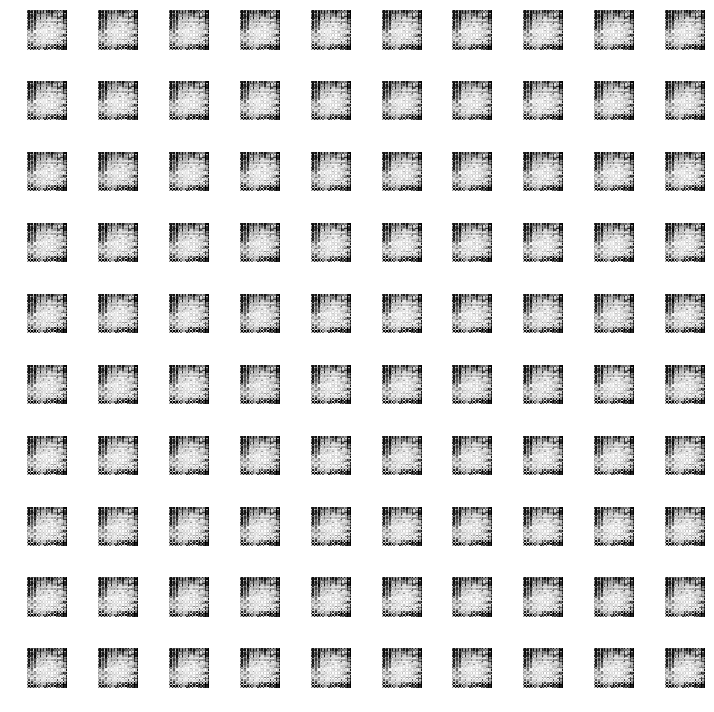

>Saved: generated_plot_0005.png and model_0005.h5
>6, 1/468, dr[0.000,0.738], df[0.000,0.249], g[-12.235,0.399]
>6, 2/468, dr[0.000,0.851], df[0.000,0.058], g[-12.264,0.179]
>6, 3/468, dr[0.000,0.470], df[0.000,0.143], g[-12.269,0.068]
>6, 4/468, dr[0.000,0.560], df[0.000,0.230], g[-12.307,0.185]
>6, 5/468, dr[0.000,0.609], df[0.000,0.098], g[-12.323,0.087]
>6, 6/468, dr[0.000,0.465], df[0.000,0.105], g[-12.339,0.161]
>6, 7/468, dr[0.000,0.529], df[0.000,0.229], g[-12.481,0.152]
>6, 8/468, dr[0.000,0.453], df[0.000,0.086], g[-12.545,0.129]
>6, 9/468, dr[0.000,0.603], df[0.000,0.105], g[-12.495,0.081]
>6, 10/468, dr[0.000,0.559], df[0.000,0.061], g[-12.474,0.063]
>6, 11/468, dr[0.000,0.534], df[0.000,0.053], g[-12.463,0.076]
>6, 12/468, dr[0.000,0.748], df[0.000,0.091], g[-12.516,0.045]
>6, 13/468, dr[0.000,0.587], df[0.000,0.137], g[-12.630,0.183]
>6, 14/468, dr[0.000,1.009], df[0.000,0.052], g[-12.379,0.070]
>6, 15/468, dr[0.000,0.861], df[0.000,0.076], g[-12.229,0.093]
>6, 16/468, dr

>6, 134/468, dr[0.000,0.553], df[0.000,0.049], g[-12.422,0.142]
>6, 135/468, dr[0.000,0.368], df[0.000,0.226], g[-12.286,0.081]
>6, 136/468, dr[0.000,0.670], df[0.000,0.070], g[-12.529,0.054]
>6, 137/468, dr[0.000,0.475], df[0.000,0.209], g[-12.473,0.093]
>6, 138/468, dr[0.000,0.608], df[0.000,0.047], g[-12.541,0.121]
>6, 139/468, dr[0.000,0.550], df[0.000,0.253], g[-12.578,0.177]
>6, 140/468, dr[0.000,0.436], df[0.000,0.192], g[-12.591,0.072]
>6, 141/468, dr[0.000,0.437], df[0.000,0.214], g[-12.393,0.098]
>6, 142/468, dr[0.000,0.614], df[0.000,0.080], g[-12.576,0.091]
>6, 143/468, dr[0.000,0.808], df[0.000,0.046], g[-12.356,0.089]
>6, 144/468, dr[0.000,0.470], df[0.000,0.123], g[-12.601,0.186]
>6, 145/468, dr[0.000,0.831], df[0.000,0.141], g[-12.619,0.070]
>6, 146/468, dr[0.000,0.756], df[0.000,0.130], g[-12.322,0.122]
>6, 147/468, dr[0.000,0.407], df[0.000,0.101], g[-12.633,0.042]
>6, 148/468, dr[0.000,0.490], df[0.000,0.021], g[-12.726,0.072]
>6, 149/468, dr[0.000,0.525], df[0.000,0

>6, 267/468, dr[0.000,0.290], df[0.000,0.072], g[-12.914,0.084]
>6, 268/468, dr[0.000,0.349], df[0.000,0.036], g[-12.958,0.132]
>6, 269/468, dr[0.000,0.444], df[0.000,0.129], g[-12.947,0.124]
>6, 270/468, dr[0.000,0.346], df[0.000,0.074], g[-12.778,0.071]
>6, 271/468, dr[0.000,0.625], df[0.000,0.088], g[-12.901,0.167]
>6, 272/468, dr[0.000,0.748], df[0.000,0.144], g[-13.009,0.188]
>6, 273/468, dr[0.000,0.657], df[0.000,0.071], g[-12.817,0.083]
>6, 274/468, dr[0.000,0.764], df[0.000,0.142], g[-12.675,0.071]
>6, 275/468, dr[0.000,0.484], df[0.000,0.358], g[-12.729,0.153]
>6, 276/468, dr[0.000,0.844], df[0.000,0.135], g[-12.765,0.098]
>6, 277/468, dr[0.000,0.875], df[0.000,0.180], g[-12.888,0.161]
>6, 278/468, dr[0.000,0.416], df[0.000,0.214], g[-12.817,0.161]
>6, 279/468, dr[0.000,0.615], df[0.000,0.181], g[-12.759,0.135]
>6, 280/468, dr[0.000,0.519], df[0.000,0.043], g[-12.767,0.096]
>6, 281/468, dr[0.000,0.571], df[0.000,0.163], g[-12.785,0.079]
>6, 282/468, dr[0.000,0.495], df[0.000,0

>6, 396/468, dr[0.000,0.604], df[0.000,0.103], g[-13.055,0.070]
>6, 397/468, dr[0.000,0.487], df[0.000,0.082], g[-12.813,0.083]
>6, 398/468, dr[0.000,0.386], df[0.000,0.131], g[-13.111,0.085]
>6, 399/468, dr[0.000,0.636], df[0.000,0.084], g[-12.990,0.190]
>6, 400/468, dr[0.000,0.570], df[0.000,0.096], g[-13.017,0.112]
>6, 401/468, dr[0.000,0.747], df[0.000,0.227], g[-12.945,0.203]
>6, 402/468, dr[0.000,0.338], df[0.000,0.141], g[-12.947,0.188]
>6, 403/468, dr[0.000,0.446], df[0.000,0.177], g[-12.763,0.112]
>6, 404/468, dr[0.000,0.504], df[0.000,0.176], g[-12.866,0.061]
>6, 405/468, dr[0.000,0.757], df[0.000,0.105], g[-12.933,0.118]
>6, 406/468, dr[0.000,0.659], df[0.000,0.105], g[-12.794,0.150]
>6, 407/468, dr[0.000,0.420], df[0.000,0.137], g[-12.772,0.201]
>6, 408/468, dr[0.000,0.351], df[0.000,0.066], g[-12.702,0.136]
>6, 409/468, dr[0.000,0.632], df[0.000,0.070], g[-12.804,0.149]
>6, 410/468, dr[0.000,0.434], df[0.000,0.100], g[-12.890,0.178]
>6, 411/468, dr[0.000,0.485], df[0.000,0

>7, 58/468, dr[0.000,0.576], df[0.000,0.212], g[-12.961,0.270]
>7, 59/468, dr[0.000,0.663], df[0.000,0.105], g[-12.972,0.084]
>7, 60/468, dr[0.000,0.440], df[0.000,0.047], g[-12.806,0.082]
>7, 61/468, dr[0.000,0.588], df[0.000,0.154], g[-12.923,0.128]
>7, 62/468, dr[0.000,0.454], df[0.000,0.075], g[-12.948,0.140]
>7, 63/468, dr[0.000,0.558], df[0.000,0.191], g[-12.945,0.078]
>7, 64/468, dr[0.000,0.555], df[0.000,0.185], g[-12.991,0.210]
>7, 65/468, dr[0.000,0.394], df[0.000,0.138], g[-12.906,0.220]
>7, 66/468, dr[0.000,0.735], df[0.000,0.227], g[-12.827,0.321]
>7, 67/468, dr[0.000,0.959], df[0.000,0.199], g[-12.741,0.154]
>7, 68/468, dr[0.000,0.715], df[0.000,0.220], g[-12.725,0.111]
>7, 69/468, dr[0.000,0.624], df[0.000,0.196], g[-13.004,0.210]
>7, 70/468, dr[0.000,0.659], df[0.000,0.146], g[-12.940,0.060]
>7, 71/468, dr[0.000,0.645], df[0.000,0.156], g[-12.963,0.074]
>7, 72/468, dr[0.000,0.565], df[0.000,0.152], g[-12.877,0.087]
>7, 73/468, dr[0.000,0.454], df[0.000,0.107], g[-13.012

>7, 188/468, dr[0.000,0.880], df[0.000,0.100], g[-12.772,0.229]
>7, 189/468, dr[0.000,0.403], df[0.000,0.162], g[-12.645,0.142]
>7, 190/468, dr[0.000,0.359], df[0.000,0.156], g[-12.690,0.180]
>7, 191/468, dr[0.000,0.345], df[0.000,0.097], g[-12.893,0.109]
>7, 192/468, dr[0.000,0.592], df[0.000,0.153], g[-13.054,0.096]
>7, 193/468, dr[0.000,0.701], df[0.000,0.102], g[-12.813,0.144]
>7, 194/468, dr[0.000,0.648], df[0.000,0.183], g[-12.911,0.173]
>7, 195/468, dr[0.000,0.493], df[0.000,0.091], g[-12.516,0.150]
>7, 196/468, dr[0.000,0.435], df[0.000,0.112], g[-12.899,0.095]
>7, 197/468, dr[0.000,0.583], df[0.000,0.128], g[-12.626,0.114]
>7, 198/468, dr[0.000,0.781], df[0.000,0.154], g[-12.655,0.160]
>7, 199/468, dr[0.000,0.473], df[0.000,0.123], g[-12.768,0.129]
>7, 200/468, dr[0.000,0.599], df[0.000,0.077], g[-12.815,0.122]
>7, 201/468, dr[0.000,0.609], df[0.000,0.077], g[-12.775,0.120]
>7, 202/468, dr[0.000,0.676], df[0.000,0.078], g[-12.681,0.069]
>7, 203/468, dr[0.000,0.400], df[0.000,0

>7, 317/468, dr[0.000,0.521], df[0.000,0.123], g[-12.984,0.102]
>7, 318/468, dr[0.000,0.408], df[0.000,0.145], g[-13.273,0.146]
>7, 319/468, dr[0.000,0.651], df[0.000,0.144], g[-13.070,0.243]
>7, 320/468, dr[0.000,0.812], df[0.000,0.106], g[-13.078,0.159]
>7, 321/468, dr[0.000,0.626], df[0.000,0.110], g[-13.259,0.127]
>7, 322/468, dr[0.000,0.544], df[0.000,0.139], g[-13.227,0.145]
>7, 323/468, dr[0.000,0.543], df[0.000,0.124], g[-13.088,0.083]
>7, 324/468, dr[0.000,0.529], df[0.000,0.129], g[-13.225,0.068]
>7, 325/468, dr[0.000,0.391], df[0.000,0.036], g[-13.149,0.076]
>7, 326/468, dr[0.000,0.577], df[0.000,0.088], g[-13.056,0.063]
>7, 327/468, dr[0.000,0.761], df[0.000,0.140], g[-12.899,0.089]
>7, 328/468, dr[0.000,0.453], df[0.000,0.217], g[-13.051,0.139]
>7, 329/468, dr[0.000,0.580], df[0.000,0.056], g[-13.149,0.131]
>7, 330/468, dr[0.000,0.589], df[0.000,0.166], g[-13.248,0.167]
>7, 331/468, dr[0.000,0.642], df[0.000,0.078], g[-13.148,0.059]
>7, 332/468, dr[0.000,0.821], df[0.000,0

>7, 449/468, dr[0.000,0.486], df[0.000,0.047], g[-13.383,0.100]
>7, 450/468, dr[0.000,0.466], df[0.000,0.051], g[-13.293,0.120]
>7, 451/468, dr[0.000,0.639], df[0.000,0.039], g[-13.230,0.032]
>7, 452/468, dr[0.000,0.472], df[0.000,0.170], g[-13.238,0.229]
>7, 453/468, dr[0.000,0.680], df[0.000,0.090], g[-13.227,0.155]
>7, 454/468, dr[0.000,0.347], df[0.000,0.108], g[-13.180,0.055]
>7, 455/468, dr[0.000,0.373], df[0.000,0.114], g[-13.374,0.148]
>7, 456/468, dr[0.000,0.413], df[0.000,0.140], g[-13.423,0.070]
>7, 457/468, dr[0.000,0.797], df[0.000,0.141], g[-13.372,0.114]
>7, 458/468, dr[0.000,0.611], df[0.000,0.053], g[-13.532,0.065]
>7, 459/468, dr[0.000,0.468], df[0.000,0.064], g[-13.337,0.090]
>7, 460/468, dr[0.000,0.649], df[0.000,0.099], g[-13.618,0.038]
>7, 461/468, dr[0.000,0.513], df[0.000,0.064], g[-13.359,0.124]
>7, 462/468, dr[0.000,0.591], df[0.000,0.044], g[-13.363,0.101]
>7, 463/468, dr[0.000,0.309], df[0.000,0.084], g[-13.468,0.122]
>7, 464/468, dr[0.000,0.583], df[0.000,0

>8, 111/468, dr[0.000,0.658], df[0.000,0.062], g[-13.805,0.114]
>8, 112/468, dr[0.000,0.379], df[0.000,0.091], g[-13.723,0.049]
>8, 113/468, dr[0.000,0.486], df[0.000,0.134], g[-13.673,0.073]
>8, 114/468, dr[0.000,0.574], df[0.000,0.070], g[-13.785,0.045]
>8, 115/468, dr[0.000,0.642], df[0.000,0.181], g[-13.608,0.198]
>8, 116/468, dr[0.000,0.465], df[0.000,0.057], g[-13.664,0.152]
>8, 117/468, dr[0.000,0.629], df[0.000,0.172], g[-13.696,0.154]
>8, 118/468, dr[0.000,0.566], df[0.000,0.078], g[-13.727,0.181]
>8, 119/468, dr[0.000,0.508], df[0.000,0.087], g[-13.625,0.122]
>8, 120/468, dr[0.000,0.626], df[0.000,0.084], g[-13.618,0.131]
>8, 121/468, dr[0.000,0.616], df[0.000,0.089], g[-13.559,0.193]
>8, 122/468, dr[0.000,0.524], df[0.000,0.107], g[-13.721,0.104]
>8, 123/468, dr[0.000,0.574], df[0.000,0.118], g[-13.694,0.108]
>8, 124/468, dr[0.000,0.672], df[0.000,0.076], g[-13.676,0.097]
>8, 125/468, dr[0.000,0.604], df[0.000,0.122], g[-13.748,0.127]
>8, 126/468, dr[0.000,0.468], df[0.000,0

>8, 242/468, dr[0.000,0.608], df[0.000,0.056], g[-14.030,0.070]
>8, 243/468, dr[0.000,0.366], df[0.000,0.142], g[-13.979,0.178]
>8, 244/468, dr[0.000,0.700], df[0.000,0.231], g[-13.848,0.063]
>8, 245/468, dr[0.000,0.473], df[0.000,0.260], g[-13.957,0.070]
>8, 246/468, dr[0.000,0.859], df[0.000,0.065], g[-13.891,0.065]
>8, 247/468, dr[0.000,0.487], df[0.000,0.102], g[-13.978,0.145]
>8, 248/468, dr[0.000,0.385], df[0.000,0.108], g[-14.126,0.115]
>8, 249/468, dr[0.000,0.476], df[0.000,0.077], g[-14.081,0.218]
>8, 250/468, dr[0.000,0.710], df[0.000,0.139], g[-14.094,0.103]
>8, 251/468, dr[0.000,0.805], df[0.000,0.096], g[-13.840,0.139]
>8, 252/468, dr[0.000,0.398], df[0.000,0.068], g[-14.019,0.161]
>8, 253/468, dr[0.000,0.391], df[0.000,0.133], g[-14.154,0.121]
>8, 254/468, dr[0.000,0.453], df[0.000,0.063], g[-14.090,0.045]
>8, 255/468, dr[0.000,0.407], df[0.000,0.047], g[-13.689,0.114]
>8, 256/468, dr[0.000,0.589], df[0.000,0.067], g[-13.837,0.065]
>8, 257/468, dr[0.000,0.665], df[0.000,0

>8, 375/468, dr[0.000,0.529], df[0.000,0.111], g[-13.828,0.053]
>8, 376/468, dr[0.000,0.606], df[0.000,0.071], g[-13.857,0.134]
>8, 377/468, dr[0.000,0.514], df[0.000,0.069], g[-13.868,0.138]
>8, 378/468, dr[0.000,0.327], df[0.000,0.126], g[-13.570,0.172]
>8, 379/468, dr[0.000,0.556], df[0.000,0.246], g[-13.518,0.127]
>8, 380/468, dr[0.000,0.658], df[0.000,0.158], g[-13.715,0.140]
>8, 381/468, dr[0.000,0.389], df[0.000,0.102], g[-13.792,0.265]
>8, 382/468, dr[0.000,0.656], df[0.000,0.082], g[-13.891,0.201]
>8, 383/468, dr[0.000,0.437], df[0.000,0.287], g[-13.815,0.130]
>8, 384/468, dr[0.000,0.507], df[0.000,0.121], g[-13.780,0.086]
>8, 385/468, dr[0.000,0.588], df[0.000,0.120], g[-13.992,0.067]
>8, 386/468, dr[0.000,0.590], df[0.000,0.156], g[-13.948,0.138]
>8, 387/468, dr[0.000,0.616], df[0.000,0.104], g[-13.846,0.121]
>8, 388/468, dr[0.000,0.813], df[0.000,0.072], g[-13.941,0.117]
>8, 389/468, dr[0.000,0.350], df[0.000,0.064], g[-13.918,0.048]
>8, 390/468, dr[0.000,0.355], df[0.000,0

>9, 169/468, dr[0.000,0.827], df[0.000,0.092], g[-14.144,0.069]
>9, 170/468, dr[0.000,0.732], df[0.000,0.190], g[-14.114,0.086]
>9, 171/468, dr[0.000,0.656], df[0.000,0.059], g[-14.082,0.107]
>9, 172/468, dr[0.000,0.622], df[0.000,0.183], g[-13.871,0.125]
>9, 173/468, dr[0.000,0.749], df[0.000,0.043], g[-13.614,0.169]
>9, 174/468, dr[0.000,0.447], df[0.000,0.123], g[-13.862,0.184]
>9, 175/468, dr[0.000,0.447], df[0.000,0.086], g[-14.047,0.086]
>9, 176/468, dr[0.000,0.448], df[0.000,0.182], g[-13.993,0.069]
>9, 177/468, dr[0.000,0.530], df[0.000,0.036], g[-14.228,0.058]
>9, 178/468, dr[0.000,0.656], df[0.000,0.095], g[-14.034,0.087]
>9, 179/468, dr[0.000,0.561], df[0.000,0.075], g[-14.090,0.065]
>9, 180/468, dr[0.000,0.459], df[0.000,0.036], g[-14.165,0.115]
>9, 181/468, dr[0.000,0.399], df[0.000,0.129], g[-14.177,0.223]
>9, 182/468, dr[0.000,0.339], df[0.000,0.138], g[-14.092,0.141]
>9, 183/468, dr[0.000,0.262], df[0.000,0.120], g[-14.299,0.133]
>9, 184/468, dr[0.000,0.327], df[0.000,0

>9, 300/468, dr[0.000,0.654], df[0.000,0.053], g[-14.580,0.151]
>9, 301/468, dr[0.000,0.476], df[0.000,0.105], g[-14.375,0.107]
>9, 302/468, dr[0.000,0.655], df[0.000,0.090], g[-14.508,0.074]
>9, 303/468, dr[0.000,0.435], df[0.000,0.139], g[-14.398,0.116]
>9, 304/468, dr[0.000,0.283], df[0.000,0.189], g[-14.337,0.074]
>9, 305/468, dr[0.000,0.480], df[0.000,0.147], g[-14.364,0.104]
>9, 306/468, dr[0.000,0.745], df[0.000,0.076], g[-14.289,0.130]
>9, 307/468, dr[0.000,0.399], df[0.000,0.117], g[-14.437,0.112]
>9, 308/468, dr[0.000,0.352], df[0.000,0.161], g[-14.412,0.243]
>9, 309/468, dr[0.000,0.568], df[0.000,0.023], g[-14.397,0.098]
>9, 310/468, dr[0.000,0.538], df[0.000,0.123], g[-14.350,0.094]
>9, 311/468, dr[0.000,0.495], df[0.000,0.122], g[-14.320,0.079]
>9, 312/468, dr[0.000,0.476], df[0.000,0.072], g[-14.451,0.089]
>9, 313/468, dr[0.000,0.585], df[0.000,0.071], g[-14.269,0.054]
>9, 314/468, dr[0.000,0.364], df[0.000,0.154], g[-14.397,0.077]
>9, 315/468, dr[0.000,0.515], df[0.000,0

>9, 431/468, dr[0.000,0.502], df[0.000,0.058], g[-14.492,0.099]
>9, 432/468, dr[0.000,0.644], df[0.000,0.069], g[-14.518,0.069]
>9, 433/468, dr[0.000,0.595], df[0.000,0.105], g[-14.684,0.103]
>9, 434/468, dr[0.000,0.242], df[0.000,0.249], g[-14.368,0.501]
>9, 435/468, dr[0.000,0.352], df[0.000,0.281], g[-14.252,0.276]
>9, 436/468, dr[0.000,0.392], df[0.000,0.178], g[-14.155,0.207]
>9, 437/468, dr[0.000,0.569], df[0.000,0.175], g[-13.868,0.171]
>9, 438/468, dr[0.000,0.401], df[0.000,0.089], g[-14.006,0.142]
>9, 439/468, dr[0.000,0.553], df[0.000,0.417], g[-14.022,0.203]
>9, 440/468, dr[0.000,0.710], df[0.000,0.230], g[-13.871,0.155]
>9, 441/468, dr[0.000,0.353], df[0.000,0.290], g[-13.891,0.266]
>9, 442/468, dr[0.000,0.420], df[0.000,0.163], g[-13.853,0.193]
>9, 443/468, dr[0.000,0.477], df[0.000,0.158], g[-13.943,0.185]
>9, 444/468, dr[0.000,0.514], df[0.000,0.068], g[-14.044,0.107]
>9, 445/468, dr[0.000,0.666], df[0.000,0.167], g[-14.261,0.111]
>9, 446/468, dr[0.000,0.508], df[0.000,0

>10, 92/468, dr[0.000,0.566], df[0.000,0.034], g[-14.575,0.057]
>10, 93/468, dr[0.000,0.322], df[0.000,0.107], g[-14.588,0.104]
>10, 94/468, dr[0.000,0.379], df[0.000,0.074], g[-14.528,0.066]
>10, 95/468, dr[0.000,0.339], df[0.000,0.090], g[-14.730,0.067]
>10, 96/468, dr[0.000,0.374], df[0.000,0.055], g[-14.451,0.046]
>10, 97/468, dr[0.000,0.438], df[0.000,0.057], g[-14.590,0.050]
>10, 98/468, dr[0.000,0.407], df[0.000,0.029], g[-14.704,0.045]
>10, 99/468, dr[0.000,0.836], df[0.000,0.157], g[-14.516,0.076]
>10, 100/468, dr[0.000,0.443], df[0.000,0.063], g[-14.609,0.105]
>10, 101/468, dr[0.000,0.445], df[0.000,0.057], g[-14.723,0.080]
>10, 102/468, dr[0.000,0.435], df[0.000,0.054], g[-14.582,0.112]
>10, 103/468, dr[0.000,0.561], df[0.000,0.199], g[-14.516,0.112]
>10, 104/468, dr[0.000,0.361], df[0.000,0.154], g[-14.588,0.106]
>10, 105/468, dr[0.000,0.570], df[0.000,0.131], g[-14.622,0.151]
>10, 106/468, dr[0.000,0.391], df[0.000,0.072], g[-14.540,0.098]
>10, 107/468, dr[0.000,0.319], df

>10, 220/468, dr[0.000,0.429], df[0.000,0.145], g[-14.646,0.139]
>10, 221/468, dr[0.000,0.420], df[0.000,0.072], g[-14.496,0.173]
>10, 222/468, dr[0.000,0.327], df[0.000,0.176], g[-14.636,0.089]
>10, 223/468, dr[0.000,0.549], df[0.000,0.121], g[-14.702,0.098]
>10, 224/468, dr[0.000,0.742], df[0.000,0.126], g[-14.675,0.064]
>10, 225/468, dr[0.000,0.600], df[0.000,0.129], g[-14.772,0.095]
>10, 226/468, dr[0.000,0.570], df[0.000,0.063], g[-14.810,0.049]
>10, 227/468, dr[0.000,0.500], df[0.000,0.180], g[-14.610,0.063]
>10, 228/468, dr[0.000,0.564], df[0.000,0.129], g[-14.630,0.103]
>10, 229/468, dr[0.000,0.445], df[0.000,0.110], g[-14.609,0.075]
>10, 230/468, dr[0.000,0.433], df[0.000,0.083], g[-14.788,0.068]
>10, 231/468, dr[0.000,0.526], df[0.000,0.113], g[-14.474,0.092]
>10, 232/468, dr[0.000,0.480], df[0.000,0.076], g[-14.485,0.165]
>10, 233/468, dr[0.000,0.393], df[0.000,0.236], g[-14.679,0.097]
>10, 234/468, dr[0.000,0.364], df[0.000,0.027], g[-14.409,0.139]
>10, 235/468, dr[0.000,0.

>10, 347/468, dr[0.000,0.284], df[0.000,0.061], g[-14.850,0.076]
>10, 348/468, dr[0.000,0.590], df[0.000,0.080], g[-14.842,0.146]
>10, 349/468, dr[0.000,0.373], df[0.000,0.143], g[-14.890,0.075]
>10, 350/468, dr[0.000,0.524], df[0.000,0.056], g[-14.648,0.079]
>10, 351/468, dr[0.000,0.351], df[0.000,0.081], g[-14.747,0.076]
>10, 352/468, dr[0.000,0.590], df[0.000,0.093], g[-14.782,0.037]
>10, 353/468, dr[0.000,0.498], df[0.000,0.012], g[-14.928,0.082]
>10, 354/468, dr[0.000,0.418], df[0.000,0.160], g[-14.977,0.133]
>10, 355/468, dr[0.000,0.581], df[0.000,0.059], g[-15.017,0.083]
>10, 356/468, dr[0.000,0.702], df[0.000,0.048], g[-15.002,0.099]
>10, 357/468, dr[0.000,0.433], df[0.000,0.101], g[-14.849,0.083]
>10, 358/468, dr[0.000,0.835], df[0.000,0.196], g[-15.047,0.053]
>10, 359/468, dr[0.000,0.765], df[0.000,0.033], g[-15.014,0.117]
>10, 360/468, dr[0.000,0.444], df[0.000,0.067], g[-14.923,0.031]
>10, 361/468, dr[0.000,0.354], df[0.000,0.055], g[-14.877,0.050]
>10, 362/468, dr[0.000,0.

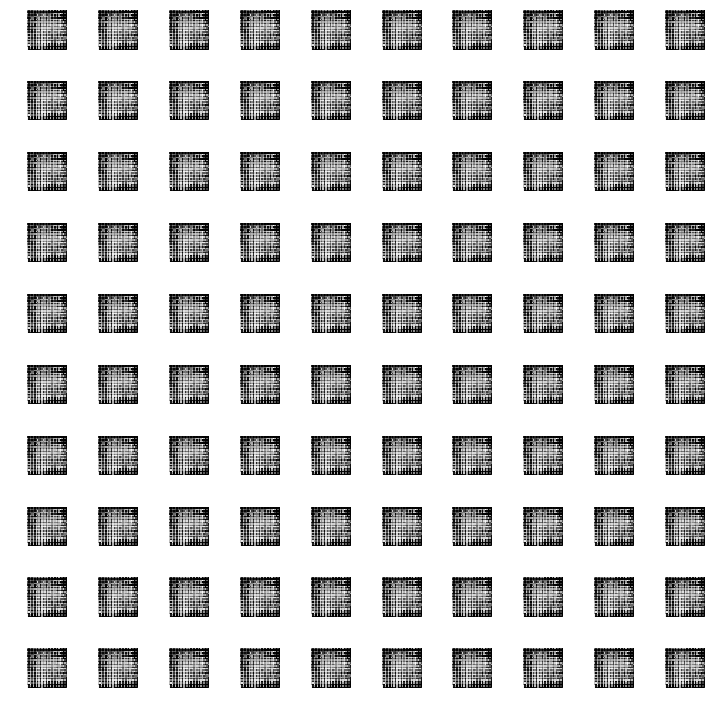

>Saved: generated_plot_0010.png and model_0010.h5
>11, 1/468, dr[0.000,0.567], df[0.000,0.049], g[-14.864,0.146]
>11, 2/468, dr[0.000,0.370], df[0.000,0.077], g[-14.837,0.094]
>11, 3/468, dr[0.000,0.615], df[0.000,0.030], g[-14.918,0.047]
>11, 4/468, dr[0.000,0.346], df[0.000,0.024], g[-14.916,0.110]
>11, 5/468, dr[0.000,0.594], df[0.000,0.051], g[-15.004,0.059]
>11, 6/468, dr[0.000,0.342], df[0.000,0.073], g[-14.785,0.049]
>11, 7/468, dr[0.000,0.241], df[0.000,0.102], g[-15.013,0.111]
>11, 8/468, dr[0.000,0.789], df[0.000,0.058], g[-14.827,0.155]
>11, 9/468, dr[0.000,0.836], df[0.000,0.046], g[-14.893,0.089]
>11, 10/468, dr[0.000,0.548], df[0.000,0.126], g[-14.741,0.101]
>11, 11/468, dr[0.000,0.423], df[0.000,0.206], g[-14.790,0.132]
>11, 12/468, dr[0.000,0.698], df[0.000,0.138], g[-14.697,0.068]
>11, 13/468, dr[0.000,0.507], df[0.000,0.023], g[-14.695,0.122]
>11, 14/468, dr[0.000,0.372], df[0.000,0.178], g[-14.341,0.318]
>11, 15/468, dr[0.000,0.393], df[0.000,0.147], g[-14.174,0.349]

>11, 130/468, dr[0.000,0.642], df[0.000,0.032], g[-15.158,0.065]
>11, 131/468, dr[0.000,0.488], df[0.000,0.022], g[-14.989,0.045]
>11, 132/468, dr[0.000,0.810], df[0.000,0.029], g[-15.199,0.051]
>11, 133/468, dr[0.000,0.425], df[0.000,0.087], g[-15.276,0.069]
>11, 134/468, dr[0.000,0.185], df[0.000,0.115], g[-14.884,0.142]
>11, 135/468, dr[0.000,0.630], df[0.000,0.208], g[-14.937,0.099]
>11, 136/468, dr[0.000,0.628], df[0.000,0.038], g[-15.037,0.067]
>11, 137/468, dr[0.000,0.550], df[0.000,0.088], g[-14.916,0.220]
>11, 138/468, dr[0.000,0.582], df[0.000,0.090], g[-15.060,0.140]
>11, 139/468, dr[0.000,0.574], df[0.000,0.091], g[-15.041,0.072]
>11, 140/468, dr[0.000,0.447], df[0.000,0.110], g[-14.925,0.033]
>11, 141/468, dr[0.000,0.563], df[0.000,0.147], g[-14.958,0.176]
>11, 142/468, dr[0.000,0.385], df[0.000,0.154], g[-14.809,0.111]
>11, 143/468, dr[0.000,0.707], df[0.000,0.050], g[-15.019,0.053]
>11, 144/468, dr[0.000,0.341], df[0.000,0.055], g[-15.164,0.080]
>11, 145/468, dr[0.000,0.

>11, 259/468, dr[0.000,0.510], df[0.000,0.065], g[-15.419,0.107]
>11, 260/468, dr[0.000,0.385], df[0.000,0.069], g[-15.185,0.019]
>11, 261/468, dr[0.000,0.711], df[0.000,0.055], g[-15.454,0.036]
>11, 262/468, dr[0.000,0.262], df[0.000,0.069], g[-15.309,0.037]
>11, 263/468, dr[0.000,0.504], df[0.000,0.025], g[-15.292,0.119]
>11, 264/468, dr[0.000,0.468], df[0.000,0.017], g[-15.294,0.124]
>11, 265/468, dr[0.000,0.522], df[0.000,0.044], g[-15.264,0.070]
>11, 266/468, dr[0.000,0.261], df[0.000,0.176], g[-15.317,0.056]
>11, 267/468, dr[0.000,0.367], df[0.000,0.074], g[-15.243,0.101]
>11, 268/468, dr[0.000,0.763], df[0.000,0.185], g[-15.313,0.024]
>11, 269/468, dr[0.000,0.351], df[0.000,0.044], g[-15.250,0.155]
>11, 270/468, dr[0.000,0.486], df[0.000,0.089], g[-15.034,0.079]
>11, 271/468, dr[0.000,0.391], df[0.000,0.072], g[-14.960,0.036]
>11, 272/468, dr[0.000,0.666], df[0.000,0.018], g[-15.222,0.084]
>11, 273/468, dr[0.000,0.414], df[0.000,0.030], g[-15.331,0.062]
>11, 274/468, dr[0.000,0.

>11, 390/468, dr[0.000,0.445], df[0.000,0.051], g[-14.846,0.028]
>11, 391/468, dr[0.000,0.403], df[0.000,0.036], g[-15.056,0.051]
>11, 392/468, dr[0.000,0.509], df[0.000,0.148], g[-15.026,0.097]
>11, 393/468, dr[0.000,0.426], df[0.000,0.165], g[-14.652,0.102]
>11, 394/468, dr[0.000,0.423], df[0.000,0.094], g[-14.755,0.145]
>11, 395/468, dr[0.000,0.513], df[0.000,0.038], g[-15.040,0.107]
>11, 396/468, dr[0.000,0.542], df[0.000,0.035], g[-14.912,0.066]
>11, 397/468, dr[0.000,0.189], df[0.000,0.028], g[-14.949,0.094]
>11, 398/468, dr[0.000,0.460], df[0.000,0.040], g[-15.126,0.076]
>11, 399/468, dr[0.000,0.640], df[0.000,0.065], g[-15.064,0.041]
>11, 400/468, dr[0.000,0.515], df[0.000,0.082], g[-15.136,0.102]
>11, 401/468, dr[0.000,0.669], df[0.000,0.053], g[-15.116,0.066]
>11, 402/468, dr[0.000,0.465], df[0.000,0.118], g[-15.020,0.051]
>11, 403/468, dr[0.000,0.397], df[0.000,0.036], g[-15.128,0.090]
>11, 404/468, dr[0.000,0.381], df[0.000,0.071], g[-14.940,0.110]
>11, 405/468, dr[0.000,0.

>12, 50/468, dr[0.000,0.482], df[0.000,0.041], g[-15.189,0.052]
>12, 51/468, dr[0.000,0.340], df[0.000,0.019], g[-15.178,0.084]
>12, 52/468, dr[0.000,0.448], df[0.000,0.030], g[-15.216,0.059]
>12, 53/468, dr[0.000,0.465], df[0.000,0.084], g[-15.120,0.064]
>12, 54/468, dr[0.000,0.417], df[0.000,0.013], g[-15.380,0.036]
>12, 55/468, dr[0.000,0.561], df[0.000,0.052], g[-15.261,0.101]
>12, 56/468, dr[0.000,0.459], df[0.000,0.053], g[-15.235,0.072]
>12, 57/468, dr[0.000,0.582], df[0.000,0.029], g[-15.040,0.058]
>12, 58/468, dr[0.000,0.597], df[0.000,0.038], g[-15.286,0.067]
>12, 59/468, dr[0.000,0.294], df[0.000,0.030], g[-15.321,0.060]
>12, 60/468, dr[0.000,0.672], df[0.000,0.030], g[-15.254,0.035]
>12, 61/468, dr[0.000,0.363], df[0.000,0.118], g[-15.085,0.078]
>12, 62/468, dr[0.000,0.501], df[0.000,0.103], g[-15.262,0.122]
>12, 63/468, dr[0.000,0.527], df[0.000,0.036], g[-15.081,0.110]
>12, 64/468, dr[0.000,0.507], df[0.000,0.043], g[-15.226,0.103]
>12, 65/468, dr[0.000,0.612], df[0.000,0

>12, 179/468, dr[0.000,0.457], df[0.000,0.010], g[-15.493,0.045]
>12, 180/468, dr[0.000,0.624], df[0.000,0.039], g[-15.597,0.061]
>12, 181/468, dr[0.000,0.281], df[0.000,0.018], g[-15.511,0.041]
>12, 182/468, dr[0.000,0.354], df[0.000,0.083], g[-15.281,0.066]
>12, 183/468, dr[0.000,0.532], df[0.000,0.020], g[-15.359,0.046]
>12, 184/468, dr[0.000,0.331], df[0.000,0.100], g[-15.376,0.088]
>12, 185/468, dr[0.000,0.647], df[0.000,0.123], g[-15.394,0.062]
>12, 186/468, dr[0.000,0.552], df[0.000,0.049], g[-15.458,0.107]
>12, 187/468, dr[0.000,0.351], df[0.000,0.089], g[-15.201,0.133]
>12, 188/468, dr[0.000,0.674], df[0.000,0.095], g[-15.205,0.103]
>12, 189/468, dr[0.000,0.668], df[0.000,0.135], g[-15.223,0.065]
>12, 190/468, dr[0.000,0.559], df[0.000,0.114], g[-15.264,0.077]
>12, 191/468, dr[0.000,0.442], df[0.000,0.022], g[-15.068,0.056]
>12, 192/468, dr[0.000,0.526], df[0.000,0.059], g[-15.321,0.070]
>12, 193/468, dr[0.000,0.384], df[0.000,0.061], g[-14.940,0.074]
>12, 194/468, dr[0.000,0.

>12, 308/468, dr[0.000,0.575], df[0.000,0.146], g[-15.328,0.101]
>12, 309/468, dr[0.000,0.592], df[0.000,0.107], g[-15.519,0.184]
>12, 310/468, dr[0.000,0.282], df[0.000,0.062], g[-15.511,0.095]
>12, 311/468, dr[0.000,0.383], df[0.000,0.028], g[-15.421,0.124]
>12, 312/468, dr[0.000,0.294], df[0.000,0.037], g[-15.561,0.104]
>12, 313/468, dr[0.000,0.595], df[0.000,0.048], g[-15.483,0.102]
>12, 314/468, dr[0.000,0.540], df[0.000,0.026], g[-15.443,0.054]
>12, 315/468, dr[0.000,0.506], df[0.000,0.066], g[-15.525,0.050]
>12, 316/468, dr[0.000,0.478], df[0.000,0.113], g[-15.443,0.029]
>12, 317/468, dr[0.000,0.566], df[0.000,0.025], g[-15.383,0.114]
>12, 318/468, dr[0.000,0.413], df[0.000,0.065], g[-15.478,0.127]
>12, 319/468, dr[0.000,0.462], df[0.000,0.026], g[-15.436,0.066]
>12, 320/468, dr[0.000,0.473], df[0.000,0.041], g[-15.489,0.090]
>12, 321/468, dr[0.000,0.430], df[0.000,0.058], g[-15.385,0.033]
>12, 322/468, dr[0.000,0.289], df[0.000,0.029], g[-15.414,0.032]
>12, 323/468, dr[0.000,0.

>12, 435/468, dr[0.000,0.447], df[0.000,0.074], g[-15.691,0.062]
>12, 436/468, dr[0.000,0.406], df[0.000,0.041], g[-15.664,0.068]
>12, 437/468, dr[0.000,0.457], df[0.000,0.034], g[-15.643,0.076]
>12, 438/468, dr[0.000,0.578], df[0.000,0.039], g[-15.618,0.031]
>12, 439/468, dr[0.000,0.430], df[0.000,0.039], g[-15.625,0.046]
>12, 440/468, dr[0.000,0.457], df[0.000,0.037], g[-15.533,0.021]
>12, 441/468, dr[0.000,0.469], df[0.000,0.035], g[-15.622,0.083]
>12, 442/468, dr[0.000,0.626], df[0.000,0.061], g[-15.670,0.064]
>12, 443/468, dr[0.000,0.594], df[0.000,0.013], g[-15.640,0.063]
>12, 444/468, dr[0.000,0.431], df[0.000,0.022], g[-15.702,0.044]
>12, 445/468, dr[0.000,0.545], df[0.000,0.110], g[-15.676,0.073]
>12, 446/468, dr[0.000,0.457], df[0.000,0.012], g[-15.568,0.029]
>12, 447/468, dr[0.000,0.245], df[0.000,0.024], g[-15.616,0.054]
>12, 448/468, dr[0.000,0.539], df[0.000,0.054], g[-15.625,0.027]
>12, 449/468, dr[0.000,0.326], df[0.000,0.036], g[-15.603,0.024]
>12, 450/468, dr[0.000,0.

>13, 95/468, dr[0.000,0.442], df[0.000,0.844], g[-14.007,0.558]
>13, 96/468, dr[0.000,0.234], df[0.000,0.669], g[-14.689,0.799]
>13, 97/468, dr[0.000,0.413], df[0.000,0.351], g[-14.856,0.404]
>13, 98/468, dr[0.000,0.364], df[0.000,0.203], g[-14.997,0.177]
>13, 99/468, dr[0.000,0.465], df[0.000,0.224], g[-15.319,0.113]
>13, 100/468, dr[0.000,0.540], df[0.000,0.103], g[-15.494,0.075]
>13, 101/468, dr[0.000,0.483], df[0.000,0.090], g[-15.527,0.093]
>13, 102/468, dr[0.000,0.487], df[0.000,0.056], g[-15.575,0.097]
>13, 103/468, dr[0.000,0.435], df[0.000,0.073], g[-15.549,0.069]
>13, 104/468, dr[0.000,0.587], df[0.000,0.082], g[-15.688,0.028]
>13, 105/468, dr[0.000,0.676], df[0.000,0.139], g[-15.602,0.098]
>13, 106/468, dr[0.000,0.434], df[0.000,0.068], g[-15.621,0.037]
>13, 107/468, dr[0.000,0.493], df[0.000,0.014], g[-15.611,0.070]
>13, 108/468, dr[0.000,0.351], df[0.000,0.031], g[-15.565,0.037]
>13, 109/468, dr[0.000,0.629], df[0.000,0.017], g[-15.631,0.019]
>13, 110/468, dr[0.000,0.388],

>13, 224/468, dr[0.000,0.580], df[0.000,0.043], g[-15.823,0.040]
>13, 225/468, dr[0.000,0.323], df[0.000,0.086], g[-15.863,0.012]
>13, 226/468, dr[0.000,0.437], df[0.000,0.005], g[-15.853,0.047]
>13, 227/468, dr[0.000,0.360], df[0.000,0.076], g[-15.846,0.026]
>13, 228/468, dr[0.000,0.563], df[0.000,0.049], g[-15.823,0.008]
>13, 229/468, dr[0.000,0.520], df[0.000,0.018], g[-15.814,0.017]
>13, 230/468, dr[0.000,0.365], df[0.000,0.033], g[-15.868,0.017]
>13, 231/468, dr[0.000,0.542], df[0.000,0.041], g[-15.828,0.006]
>13, 232/468, dr[0.000,0.606], df[0.000,0.006], g[-15.899,0.025]
>13, 233/468, dr[0.000,0.689], df[0.000,0.014], g[-15.804,0.040]
>13, 234/468, dr[0.000,0.348], df[0.000,0.032], g[-15.879,0.029]
>13, 235/468, dr[0.000,0.490], df[0.000,0.042], g[-15.795,0.017]
>13, 236/468, dr[0.000,0.329], df[0.000,0.055], g[-15.750,0.031]
>13, 237/468, dr[0.000,0.283], df[0.000,0.025], g[-15.823,0.027]
>13, 238/468, dr[0.000,0.459], df[0.000,0.011], g[-15.883,0.049]
>13, 239/468, dr[0.000,0.

>13, 351/468, dr[0.000,0.568], df[0.000,0.033], g[-15.875,0.010]
>13, 352/468, dr[0.000,0.421], df[0.000,0.035], g[-15.843,0.017]
>13, 353/468, dr[0.000,0.764], df[0.000,0.023], g[-15.859,0.042]
>13, 354/468, dr[0.000,0.423], df[0.000,0.026], g[-15.907,0.016]
>13, 355/468, dr[0.000,0.381], df[0.000,0.026], g[-15.935,0.027]
>13, 356/468, dr[0.000,0.475], df[0.000,0.021], g[-15.910,0.042]
>13, 357/468, dr[0.000,0.717], df[0.000,0.041], g[-15.948,0.044]
>13, 358/468, dr[0.000,0.371], df[0.000,0.008], g[-15.865,0.026]
>13, 359/468, dr[0.000,0.279], df[0.000,0.019], g[-15.836,0.012]
>13, 360/468, dr[0.000,0.564], df[0.000,0.021], g[-15.883,0.017]
>13, 361/468, dr[0.000,0.450], df[0.000,0.033], g[-15.869,0.063]
>13, 362/468, dr[0.000,0.450], df[0.000,0.038], g[-15.909,0.025]
>13, 363/468, dr[0.000,0.227], df[0.000,0.017], g[-15.918,0.035]
>13, 364/468, dr[0.000,0.238], df[0.000,0.026], g[-15.917,0.015]
>13, 365/468, dr[0.000,0.626], df[0.000,0.034], g[-15.944,0.020]
>13, 366/468, dr[0.000,0.

>14, 10/468, dr[0.000,0.679], df[0.000,0.116], g[-15.905,0.022]
>14, 11/468, dr[0.000,0.575], df[0.000,0.038], g[-15.981,0.019]
>14, 12/468, dr[0.000,0.467], df[0.000,0.145], g[-15.842,0.067]
>14, 13/468, dr[0.000,0.468], df[0.000,0.055], g[-15.847,0.039]
>14, 14/468, dr[0.000,0.446], df[0.000,0.057], g[-15.778,0.061]
>14, 15/468, dr[0.000,0.453], df[0.000,0.042], g[-15.879,0.016]
>14, 16/468, dr[0.000,0.360], df[0.000,0.044], g[-15.920,0.040]
>14, 17/468, dr[0.000,0.401], df[0.000,0.079], g[-15.951,0.037]
>14, 18/468, dr[0.000,0.464], df[0.000,0.038], g[-15.956,0.052]
>14, 19/468, dr[0.000,0.393], df[0.000,0.051], g[-15.917,0.027]
>14, 20/468, dr[0.000,0.456], df[0.000,0.047], g[-15.882,0.066]
>14, 21/468, dr[0.000,0.433], df[0.000,0.030], g[-15.837,0.028]
>14, 22/468, dr[0.000,0.459], df[0.000,0.034], g[-15.873,0.027]
>14, 23/468, dr[0.000,0.508], df[0.000,0.020], g[-15.866,0.054]
>14, 24/468, dr[0.000,0.592], df[0.000,0.028], g[-15.939,0.017]
>14, 25/468, dr[0.000,0.600], df[0.000,0

>14, 138/468, dr[0.000,0.326], df[0.000,0.222], g[-15.433,0.140]
>14, 139/468, dr[0.000,0.642], df[0.000,0.144], g[-15.709,0.150]
>14, 140/468, dr[0.000,0.666], df[0.000,0.073], g[-15.747,0.077]
>14, 141/468, dr[0.000,0.412], df[0.000,0.070], g[-15.903,0.029]
>14, 142/468, dr[0.000,0.491], df[0.000,0.027], g[-15.893,0.028]
>14, 143/468, dr[0.000,0.456], df[0.000,0.041], g[-15.899,0.036]
>14, 144/468, dr[0.000,0.423], df[0.000,0.086], g[-15.944,0.030]
>14, 145/468, dr[0.000,0.501], df[0.000,0.015], g[-15.867,0.021]
>14, 146/468, dr[0.000,0.390], df[0.000,0.012], g[-15.952,0.011]
>14, 147/468, dr[0.000,0.512], df[0.000,0.010], g[-15.968,0.040]
>14, 148/468, dr[0.000,0.463], df[0.000,0.012], g[-15.940,0.030]
>14, 149/468, dr[0.000,0.404], df[0.000,0.010], g[-15.930,0.015]
>14, 150/468, dr[0.000,0.631], df[0.000,0.008], g[-15.989,0.012]
>14, 151/468, dr[0.000,0.568], df[0.000,0.010], g[-15.931,0.010]
>14, 152/468, dr[0.000,0.464], df[0.000,0.007], g[-16.021,0.026]
>14, 153/468, dr[0.000,0.

>14, 266/468, dr[0.000,0.570], df[0.000,0.020], g[-15.999,0.008]
>14, 267/468, dr[0.000,0.482], df[0.000,0.012], g[-16.021,0.022]
>14, 268/468, dr[0.000,0.273], df[0.000,0.007], g[-15.981,0.043]
>14, 269/468, dr[0.000,0.419], df[0.000,0.022], g[-16.056,0.017]
>14, 270/468, dr[0.000,0.501], df[0.000,0.007], g[-16.012,0.010]
>14, 271/468, dr[0.000,0.579], df[0.000,0.004], g[-16.041,0.009]
>14, 272/468, dr[0.000,0.329], df[0.000,0.010], g[-16.022,0.040]
>14, 273/468, dr[0.000,0.608], df[0.000,0.043], g[-16.056,0.015]
>14, 274/468, dr[0.000,0.600], df[0.000,0.016], g[-16.043,0.011]
>14, 275/468, dr[0.000,0.447], df[0.000,0.015], g[-16.031,0.007]
>14, 276/468, dr[0.000,0.504], df[0.000,0.064], g[-16.075,0.011]
>14, 277/468, dr[0.000,0.452], df[0.000,0.004], g[-16.065,0.018]
>14, 278/468, dr[0.000,0.430], df[0.000,0.057], g[-16.030,0.037]
>14, 279/468, dr[0.000,0.304], df[0.000,0.017], g[-16.044,0.017]
>14, 280/468, dr[0.000,0.325], df[0.000,0.074], g[-16.056,0.006]
>14, 281/468, dr[0.000,0.

>14, 396/468, dr[0.000,0.455], df[0.000,0.003], g[-16.051,0.006]
>14, 397/468, dr[0.000,0.402], df[0.000,0.038], g[-16.066,0.004]
>14, 398/468, dr[0.000,0.330], df[0.000,0.023], g[-16.054,0.007]
>14, 399/468, dr[0.000,0.468], df[0.000,0.006], g[-16.006,0.009]
>14, 400/468, dr[0.000,0.321], df[0.000,0.005], g[-16.069,0.022]
>14, 401/468, dr[0.000,0.345], df[0.000,0.012], g[-15.993,0.013]
>14, 402/468, dr[0.000,0.549], df[0.000,0.007], g[-16.077,0.008]
>14, 403/468, dr[0.000,0.576], df[0.000,0.067], g[-16.071,0.025]
>14, 404/468, dr[0.000,0.434], df[0.000,0.005], g[-16.052,0.013]
>14, 405/468, dr[0.000,0.484], df[0.000,0.005], g[-15.970,0.008]
>14, 406/468, dr[0.000,0.304], df[0.000,0.016], g[-16.065,0.009]
>14, 407/468, dr[0.000,0.735], df[0.000,0.005], g[-16.049,0.021]
>14, 408/468, dr[0.000,0.483], df[0.000,0.011], g[-16.010,0.007]
>14, 409/468, dr[0.000,0.651], df[0.000,0.008], g[-16.062,0.014]
>14, 410/468, dr[0.000,0.667], df[0.000,0.012], g[-16.018,0.006]
>14, 411/468, dr[0.000,0.

>15, 56/468, dr[0.000,0.496], df[0.000,0.010], g[-15.997,0.016]
>15, 57/468, dr[0.000,0.463], df[0.000,0.010], g[-15.984,0.007]
>15, 58/468, dr[0.000,0.385], df[0.000,0.028], g[-16.006,0.031]
>15, 59/468, dr[0.000,0.618], df[0.000,0.004], g[-16.027,0.004]
>15, 60/468, dr[0.000,0.391], df[0.000,0.015], g[-16.045,0.027]
>15, 61/468, dr[0.000,0.378], df[0.000,0.005], g[-16.021,0.012]
>15, 62/468, dr[0.000,0.428], df[0.000,0.012], g[-15.983,0.010]
>15, 63/468, dr[0.000,0.415], df[0.000,0.003], g[-16.016,0.015]
>15, 64/468, dr[0.000,0.420], df[0.000,0.004], g[-16.026,0.016]
>15, 65/468, dr[0.000,0.333], df[0.000,0.009], g[-16.006,0.021]
>15, 66/468, dr[0.000,0.313], df[0.000,0.008], g[-16.020,0.005]
>15, 67/468, dr[0.000,0.397], df[0.000,0.010], g[-16.055,0.013]
>15, 68/468, dr[0.000,0.325], df[0.000,0.014], g[-16.036,0.011]
>15, 69/468, dr[0.000,0.458], df[0.000,0.006], g[-16.041,0.007]
>15, 70/468, dr[0.000,0.476], df[0.000,0.018], g[-16.068,0.008]
>15, 71/468, dr[0.000,0.523], df[0.000,0

>15, 185/468, dr[0.000,0.445], df[0.000,0.075], g[-16.017,0.017]
>15, 186/468, dr[0.000,0.383], df[0.000,0.041], g[-15.983,0.043]
>15, 187/468, dr[0.000,0.498], df[0.000,0.036], g[-15.976,0.072]
>15, 188/468, dr[0.000,0.592], df[0.000,0.008], g[-15.914,0.022]
>15, 189/468, dr[0.000,0.493], df[0.000,0.062], g[-16.035,0.019]
>15, 190/468, dr[0.000,0.259], df[0.000,0.012], g[-15.993,0.012]
>15, 191/468, dr[0.000,0.468], df[0.000,0.013], g[-15.987,0.013]
>15, 192/468, dr[0.000,0.260], df[0.000,0.011], g[-16.027,0.013]
>15, 193/468, dr[0.000,0.481], df[0.000,0.013], g[-15.977,0.014]
>15, 194/468, dr[0.000,0.308], df[0.000,0.034], g[-16.034,0.027]
>15, 195/468, dr[0.000,0.463], df[0.000,0.020], g[-15.996,0.019]
>15, 196/468, dr[0.000,0.395], df[0.000,0.034], g[-15.991,0.020]
>15, 197/468, dr[0.000,0.674], df[0.000,0.031], g[-16.042,0.015]
>15, 198/468, dr[0.000,0.474], df[0.000,0.011], g[-16.061,0.060]
>15, 199/468, dr[0.000,0.395], df[0.000,0.003], g[-16.004,0.039]
>15, 200/468, dr[0.000,0.

>15, 315/468, dr[0.000,0.347], df[0.000,0.007], g[-16.118,0.009]
>15, 316/468, dr[0.000,0.361], df[0.000,0.009], g[-16.118,0.005]
>15, 317/468, dr[0.000,0.356], df[0.000,0.004], g[-16.118,0.032]
>15, 318/468, dr[0.000,0.700], df[0.000,0.012], g[-16.118,0.005]
>15, 319/468, dr[0.000,0.349], df[0.000,0.002], g[-16.118,0.002]
>15, 320/468, dr[0.000,0.337], df[0.000,0.002], g[-16.118,0.004]
>15, 321/468, dr[0.000,0.464], df[0.000,0.002], g[-16.118,0.001]
>15, 322/468, dr[0.000,0.362], df[0.000,0.004], g[-16.118,0.003]
>15, 323/468, dr[0.000,0.453], df[0.000,0.001], g[-16.118,0.002]
>15, 324/468, dr[0.000,0.374], df[0.000,0.005], g[-16.118,0.004]
>15, 325/468, dr[0.000,0.251], df[0.000,0.014], g[-16.118,0.017]
>15, 326/468, dr[0.000,0.519], df[0.000,0.004], g[-16.118,0.007]
>15, 327/468, dr[0.000,0.339], df[0.000,0.002], g[-16.118,0.003]
>15, 328/468, dr[0.000,0.470], df[0.000,0.003], g[-16.118,0.002]
>15, 329/468, dr[0.000,0.400], df[0.000,0.012], g[-16.118,0.002]
>15, 330/468, dr[0.000,0.

>15, 444/468, dr[0.000,0.354], df[0.000,0.001], g[-16.118,0.001]
>15, 445/468, dr[0.000,0.307], df[0.000,0.001], g[-16.118,0.001]
>15, 446/468, dr[0.000,0.441], df[0.000,0.001], g[-16.117,0.000]
>15, 447/468, dr[0.000,0.478], df[0.000,0.001], g[-16.118,0.001]
>15, 448/468, dr[0.000,0.678], df[0.000,0.002], g[-16.118,0.001]
>15, 449/468, dr[0.000,0.446], df[0.000,0.000], g[-16.118,0.001]
>15, 450/468, dr[0.000,0.375], df[0.000,0.000], g[-16.118,0.006]
>15, 451/468, dr[0.000,0.493], df[0.000,0.002], g[-16.118,0.000]
>15, 452/468, dr[0.000,0.245], df[0.000,0.000], g[-16.118,0.001]
>15, 453/468, dr[0.000,0.499], df[0.000,0.001], g[-16.118,0.003]
>15, 454/468, dr[0.000,0.532], df[0.000,0.002], g[-16.118,0.000]
>15, 455/468, dr[0.000,0.478], df[0.000,0.001], g[-16.115,0.001]
>15, 456/468, dr[0.000,0.392], df[0.000,0.000], g[-16.118,0.001]
>15, 457/468, dr[0.000,0.449], df[0.000,0.001], g[-16.118,0.000]
>15, 458/468, dr[0.000,0.297], df[0.000,0.001], g[-16.118,0.001]
>15, 459/468, dr[0.000,0.

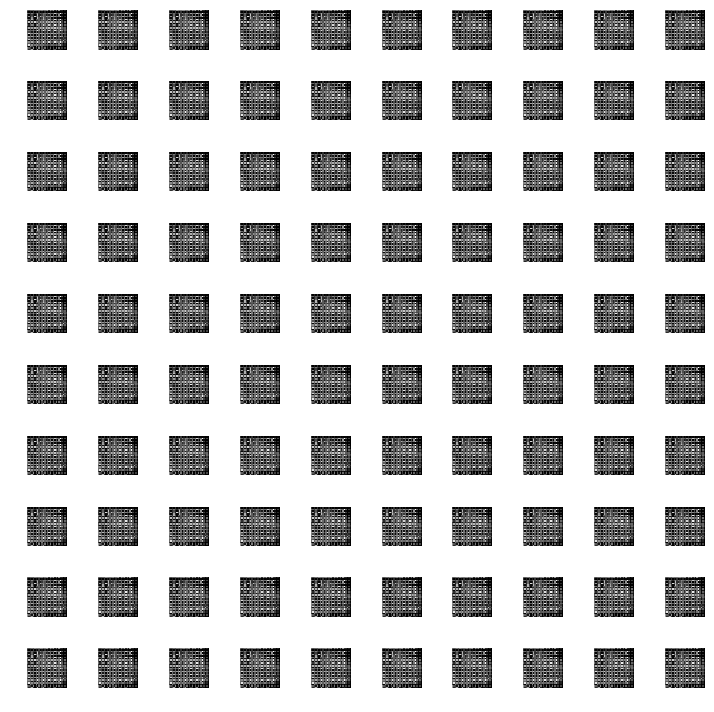

>Saved: generated_plot_0015.png and model_0015.h5
>16, 1/468, dr[0.000,0.462], df[0.000,0.001], g[-16.118,0.001]
>16, 2/468, dr[0.000,0.595], df[0.000,0.001], g[-16.118,0.000]
>16, 3/468, dr[0.000,0.541], df[0.000,0.001], g[-16.118,0.010]
>16, 4/468, dr[0.000,0.466], df[0.000,0.001], g[-16.118,0.001]
>16, 5/468, dr[0.000,0.349], df[0.000,0.002], g[-16.118,0.000]
>16, 6/468, dr[0.000,0.556], df[0.000,0.000], g[-16.118,0.001]
>16, 7/468, dr[0.000,0.607], df[0.000,0.002], g[-16.118,0.009]
>16, 8/468, dr[0.000,0.351], df[0.000,0.005], g[-16.118,0.001]
>16, 9/468, dr[0.000,0.582], df[0.000,0.000], g[-16.118,0.001]
>16, 10/468, dr[0.000,0.365], df[0.000,0.001], g[-16.118,0.001]
>16, 11/468, dr[0.000,0.543], df[0.000,0.002], g[-16.118,0.004]
>16, 12/468, dr[0.000,0.423], df[0.000,0.000], g[-16.118,0.001]
>16, 13/468, dr[0.000,0.622], df[0.000,0.001], g[-16.118,0.002]
>16, 14/468, dr[0.000,0.528], df[0.000,0.001], g[-16.118,0.001]
>16, 15/468, dr[0.000,0.309], df[0.000,0.000], g[-16.118,0.000]

>16, 131/468, dr[0.000,0.461], df[0.000,0.003], g[-16.118,0.000]
>16, 132/468, dr[0.000,0.382], df[0.000,0.001], g[-16.118,0.000]
>16, 133/468, dr[0.000,0.524], df[0.000,0.001], g[-16.118,0.001]
>16, 134/468, dr[0.000,0.524], df[0.000,0.000], g[-16.118,0.000]
>16, 135/468, dr[0.000,0.406], df[0.000,0.001], g[-16.118,0.000]
>16, 136/468, dr[0.000,0.722], df[0.000,0.000], g[-16.118,0.001]
>16, 137/468, dr[0.000,0.284], df[0.000,0.001], g[-16.118,0.000]
>16, 138/468, dr[0.000,0.433], df[0.000,0.001], g[-16.118,0.000]
>16, 139/468, dr[0.000,0.200], df[0.000,0.000], g[-16.118,0.001]
>16, 140/468, dr[0.000,0.411], df[0.000,0.000], g[-16.118,0.002]
>16, 141/468, dr[0.000,0.471], df[0.000,0.000], g[-16.118,0.000]
>16, 142/468, dr[0.000,0.574], df[0.000,0.000], g[-16.118,0.000]
>16, 143/468, dr[0.000,0.386], df[0.000,0.000], g[-16.118,0.013]
>16, 144/468, dr[0.000,0.314], df[0.000,0.000], g[-16.118,0.002]
>16, 145/468, dr[0.000,0.352], df[0.000,0.001], g[-16.118,0.003]
>16, 146/468, dr[0.000,0.

>16, 259/468, dr[0.000,0.449], df[0.000,0.003], g[-16.118,0.001]
>16, 260/468, dr[0.000,0.541], df[0.000,0.000], g[-16.118,0.001]
>16, 261/468, dr[0.000,0.381], df[0.000,0.000], g[-16.118,0.001]
>16, 262/468, dr[0.000,0.394], df[0.000,0.000], g[-16.118,0.001]
>16, 263/468, dr[0.000,0.378], df[0.000,0.000], g[-16.118,0.000]
>16, 264/468, dr[0.000,0.360], df[0.000,0.001], g[-16.118,0.001]
>16, 265/468, dr[0.000,0.379], df[0.000,0.000], g[-16.118,0.000]
>16, 266/468, dr[0.000,0.491], df[0.000,0.000], g[-16.118,0.000]
>16, 267/468, dr[0.000,0.629], df[0.000,0.000], g[-16.118,0.000]
>16, 268/468, dr[0.000,0.515], df[0.000,0.000], g[-16.118,0.001]
>16, 269/468, dr[0.000,0.402], df[0.000,0.001], g[-16.118,0.000]
>16, 270/468, dr[0.000,0.496], df[0.000,0.002], g[-16.118,0.000]
>16, 271/468, dr[0.000,0.406], df[0.000,0.001], g[-16.118,0.000]
>16, 272/468, dr[0.000,0.474], df[0.000,0.000], g[-16.118,0.001]
>16, 273/468, dr[0.000,0.388], df[0.000,0.000], g[-16.118,0.000]
>16, 274/468, dr[0.000,0.

>16, 386/468, dr[0.000,0.540], df[0.000,0.001], g[-16.118,0.000]
>16, 387/468, dr[0.000,0.526], df[0.000,0.000], g[-16.118,0.000]
>16, 388/468, dr[0.000,0.388], df[0.000,0.001], g[-16.118,0.000]
>16, 389/468, dr[0.000,0.402], df[0.000,0.000], g[-16.118,0.001]
>16, 390/468, dr[0.000,0.512], df[0.000,0.001], g[-16.118,0.000]
>16, 391/468, dr[0.000,0.516], df[0.000,0.000], g[-16.118,0.001]
>16, 392/468, dr[0.000,0.443], df[0.000,0.001], g[-16.118,0.000]
>16, 393/468, dr[0.000,0.694], df[0.000,0.001], g[-16.118,0.000]
>16, 394/468, dr[0.000,0.418], df[0.000,0.001], g[-16.118,0.000]
>16, 395/468, dr[0.000,0.374], df[0.000,0.000], g[-16.118,0.000]
>16, 396/468, dr[0.000,0.669], df[0.000,0.000], g[-16.118,0.000]
>16, 397/468, dr[0.000,0.715], df[0.000,0.000], g[-16.118,0.001]
>16, 398/468, dr[0.000,0.493], df[0.000,0.000], g[-16.118,0.001]
>16, 399/468, dr[0.000,0.428], df[0.000,0.000], g[-16.118,0.000]
>16, 400/468, dr[0.000,0.266], df[0.000,0.000], g[-16.118,0.001]
>16, 401/468, dr[0.000,0.

>17, 50/468, dr[0.000,0.395], df[0.000,0.000], g[-16.118,0.000]
>17, 51/468, dr[0.000,0.244], df[0.000,0.010], g[-16.118,0.001]
>17, 52/468, dr[0.000,0.296], df[0.000,0.000], g[-16.118,0.000]
>17, 53/468, dr[0.000,0.339], df[0.000,0.000], g[-16.118,0.001]
>17, 54/468, dr[0.000,0.532], df[0.000,0.000], g[-16.118,0.001]
>17, 55/468, dr[0.000,0.439], df[0.000,0.000], g[-16.118,0.001]
>17, 56/468, dr[0.000,0.294], df[0.000,0.000], g[-16.118,0.000]
>17, 57/468, dr[0.000,0.317], df[0.000,0.000], g[-16.118,0.000]
>17, 58/468, dr[0.000,0.463], df[0.000,0.001], g[-16.118,0.000]
>17, 59/468, dr[0.000,0.468], df[0.000,0.001], g[-16.118,0.000]
>17, 60/468, dr[0.000,0.530], df[0.000,0.001], g[-16.118,0.000]
>17, 61/468, dr[0.000,0.391], df[0.000,0.002], g[-16.118,0.001]
>17, 62/468, dr[0.000,0.425], df[0.000,0.001], g[-16.118,0.000]
>17, 63/468, dr[0.000,0.399], df[0.000,0.000], g[-16.118,0.001]
>17, 64/468, dr[0.000,0.598], df[0.000,0.000], g[-16.118,0.001]
>17, 65/468, dr[0.000,0.275], df[0.000,0

>17, 177/468, dr[0.000,0.429], df[0.000,0.001], g[-16.118,0.002]
>17, 178/468, dr[0.000,0.399], df[0.000,0.001], g[-16.118,0.000]
>17, 179/468, dr[0.000,0.345], df[0.000,0.000], g[-16.118,0.000]
>17, 180/468, dr[0.000,0.422], df[0.000,0.000], g[-16.118,0.001]
>17, 181/468, dr[0.000,0.446], df[0.000,0.000], g[-16.118,0.001]
>17, 182/468, dr[0.000,0.289], df[0.000,0.001], g[-16.118,0.001]
>17, 183/468, dr[0.000,0.587], df[0.000,0.000], g[-16.118,0.001]
>17, 184/468, dr[0.000,0.395], df[0.000,0.000], g[-16.118,0.000]
>17, 185/468, dr[0.000,0.329], df[0.000,0.000], g[-16.118,0.000]
>17, 186/468, dr[0.000,0.437], df[0.000,0.000], g[-16.118,0.001]
>17, 187/468, dr[0.000,0.427], df[0.000,0.000], g[-16.118,0.001]
>17, 188/468, dr[0.000,0.420], df[0.000,0.001], g[-16.118,0.002]
>17, 189/468, dr[0.000,0.257], df[0.000,0.001], g[-16.118,0.001]
>17, 190/468, dr[0.000,0.282], df[0.000,0.000], g[-16.118,0.000]
>17, 191/468, dr[0.000,0.474], df[0.000,0.000], g[-16.118,0.001]
>17, 192/468, dr[0.000,0.

>17, 309/468, dr[0.000,0.309], df[0.000,0.000], g[-16.118,0.000]
>17, 310/468, dr[0.000,0.350], df[0.000,0.000], g[-16.118,0.001]
>17, 311/468, dr[0.000,0.287], df[0.000,0.025], g[-16.118,0.000]
>17, 312/468, dr[0.000,0.369], df[0.000,0.000], g[-16.117,0.000]
>17, 313/468, dr[0.000,0.371], df[0.000,0.000], g[-16.118,0.001]
>17, 314/468, dr[0.000,0.456], df[0.000,0.001], g[-16.118,0.000]
>17, 315/468, dr[0.000,0.285], df[0.000,0.000], g[-16.118,0.000]
>17, 316/468, dr[0.000,0.427], df[0.000,0.000], g[-16.118,0.000]
>17, 317/468, dr[0.000,0.274], df[0.000,0.001], g[-16.118,0.000]
>17, 318/468, dr[0.000,0.247], df[0.000,0.000], g[-16.118,0.000]
>17, 319/468, dr[0.000,0.667], df[0.000,0.000], g[-16.118,0.000]
>17, 320/468, dr[0.000,0.525], df[0.000,0.000], g[-16.118,0.001]
>17, 321/468, dr[0.000,0.248], df[0.000,0.002], g[-16.118,0.001]
>17, 322/468, dr[0.000,0.536], df[0.000,0.002], g[-16.118,0.000]
>17, 323/468, dr[0.000,0.483], df[0.000,0.001], g[-16.118,0.000]
>17, 324/468, dr[0.000,0.

>17, 440/468, dr[0.000,0.507], df[0.000,0.000], g[-16.117,0.000]
>17, 441/468, dr[0.000,0.479], df[0.000,0.002], g[-16.118,0.000]
>17, 442/468, dr[0.000,0.483], df[0.000,0.000], g[-16.118,0.000]
>17, 443/468, dr[0.000,0.457], df[0.000,0.000], g[-16.118,0.000]
>17, 444/468, dr[0.000,0.516], df[0.000,0.000], g[-16.118,0.002]
>17, 445/468, dr[0.000,0.792], df[0.000,0.000], g[-16.118,0.004]
>17, 446/468, dr[0.000,0.435], df[0.000,0.002], g[-16.118,0.000]
>17, 447/468, dr[0.000,0.518], df[0.000,0.001], g[-16.118,0.000]
>17, 448/468, dr[0.000,0.568], df[0.000,0.001], g[-16.118,0.000]
>17, 449/468, dr[0.000,0.574], df[0.000,0.000], g[-16.118,0.000]
>17, 450/468, dr[0.000,0.362], df[0.000,0.000], g[-16.118,0.000]
>17, 451/468, dr[0.000,0.307], df[0.000,0.001], g[-16.118,0.001]
>17, 452/468, dr[0.000,0.280], df[0.000,0.000], g[-16.118,0.002]
>17, 453/468, dr[0.000,0.400], df[0.000,0.000], g[-16.118,0.000]
>17, 454/468, dr[0.000,0.416], df[0.000,0.000], g[-16.118,0.000]
>17, 455/468, dr[0.000,0.

>18, 100/468, dr[0.000,0.385], df[0.000,0.000], g[-16.118,0.000]
>18, 101/468, dr[0.000,0.573], df[0.000,0.001], g[-16.118,0.000]
>18, 102/468, dr[0.000,0.214], df[0.000,0.000], g[-16.118,0.000]
>18, 103/468, dr[0.000,0.510], df[0.000,0.001], g[-16.118,0.000]
>18, 104/468, dr[0.000,0.660], df[0.000,0.001], g[-16.118,0.000]
>18, 105/468, dr[0.000,0.476], df[0.000,0.001], g[-16.118,0.000]
>18, 106/468, dr[0.000,0.443], df[0.000,0.000], g[-16.118,0.000]
>18, 107/468, dr[0.000,0.356], df[0.000,0.000], g[-16.118,0.000]
>18, 108/468, dr[0.000,0.413], df[0.000,0.000], g[-16.118,0.001]
>18, 109/468, dr[0.000,0.438], df[0.000,0.001], g[-16.118,0.002]
>18, 110/468, dr[0.000,0.463], df[0.000,0.005], g[-16.118,0.001]
>18, 111/468, dr[0.000,0.448], df[0.000,0.000], g[-16.118,0.000]
>18, 112/468, dr[0.000,0.489], df[0.000,0.001], g[-16.118,0.001]
>18, 113/468, dr[0.000,0.347], df[0.000,0.001], g[-16.118,0.003]
>18, 114/468, dr[0.000,0.548], df[0.000,0.000], g[-16.118,0.000]
>18, 115/468, dr[0.000,0.

>18, 230/468, dr[0.000,0.389], df[0.000,0.000], g[-16.118,0.002]
>18, 231/468, dr[0.000,0.410], df[0.000,0.001], g[-16.117,0.001]
>18, 232/468, dr[0.000,0.313], df[0.000,0.000], g[-16.118,0.001]
>18, 233/468, dr[0.000,0.309], df[0.000,0.000], g[-16.118,0.001]
>18, 234/468, dr[0.000,0.554], df[0.000,0.000], g[-16.118,0.001]
>18, 235/468, dr[0.000,0.455], df[0.000,0.000], g[-16.118,0.001]
>18, 236/468, dr[0.000,0.330], df[0.000,0.001], g[-16.118,0.000]
>18, 237/468, dr[0.000,0.439], df[0.000,0.000], g[-16.118,0.001]
>18, 238/468, dr[0.000,0.593], df[0.000,0.000], g[-16.118,0.001]
>18, 239/468, dr[0.000,0.208], df[0.000,0.001], g[-16.118,0.001]
>18, 240/468, dr[0.000,0.568], df[0.000,0.001], g[-16.118,0.001]
>18, 241/468, dr[0.000,0.205], df[0.000,0.003], g[-16.118,0.001]
>18, 242/468, dr[0.000,0.439], df[0.000,0.000], g[-16.118,0.000]
>18, 243/468, dr[0.000,0.337], df[0.000,0.002], g[-16.118,0.001]
>18, 244/468, dr[0.000,0.577], df[0.000,0.000], g[-16.118,0.000]
>18, 245/468, dr[0.000,0.

>18, 360/468, dr[0.000,0.351], df[0.000,0.001], g[-16.118,0.000]
>18, 361/468, dr[0.000,0.438], df[0.000,0.001], g[-16.118,0.001]
>18, 362/468, dr[0.000,0.423], df[0.000,0.000], g[-16.118,0.000]
>18, 363/468, dr[0.000,0.401], df[0.000,0.000], g[-16.118,0.000]
>18, 364/468, dr[0.000,0.312], df[0.000,0.001], g[-16.118,0.000]
>18, 365/468, dr[0.000,0.588], df[0.000,0.000], g[-16.118,0.001]
>18, 366/468, dr[0.000,0.231], df[0.000,0.001], g[-16.118,0.000]
>18, 367/468, dr[0.000,0.359], df[0.000,0.000], g[-16.118,0.001]
>18, 368/468, dr[0.000,0.296], df[0.000,0.001], g[-16.118,0.000]
>18, 369/468, dr[0.000,0.326], df[0.000,0.001], g[-16.118,0.000]
>18, 370/468, dr[0.000,0.368], df[0.000,0.001], g[-16.118,0.001]
>18, 371/468, dr[0.000,0.361], df[0.000,0.000], g[-16.118,0.001]
>18, 372/468, dr[0.000,0.279], df[0.000,0.000], g[-16.118,0.000]
>18, 373/468, dr[0.000,0.404], df[0.000,0.001], g[-16.118,0.000]
>18, 374/468, dr[0.000,0.423], df[0.000,0.000], g[-16.118,0.000]
>18, 375/468, dr[0.000,0.

>19, 24/468, dr[0.000,0.338], df[0.000,0.001], g[-16.118,0.001]
>19, 25/468, dr[0.000,0.588], df[0.000,0.001], g[-16.118,0.000]
>19, 26/468, dr[0.000,0.309], df[0.000,0.000], g[-16.118,0.001]
>19, 27/468, dr[0.000,0.282], df[0.000,0.001], g[-16.118,0.000]
>19, 28/468, dr[0.000,0.192], df[0.000,0.000], g[-16.118,0.000]
>19, 29/468, dr[0.000,0.504], df[0.000,0.000], g[-16.118,0.002]
>19, 30/468, dr[0.000,0.492], df[0.000,0.002], g[-16.118,0.000]
>19, 31/468, dr[0.000,0.324], df[0.000,0.000], g[-16.118,0.001]
>19, 32/468, dr[0.000,0.292], df[0.000,0.000], g[-16.117,0.001]
>19, 33/468, dr[0.000,0.674], df[0.000,0.000], g[-16.118,0.000]
>19, 34/468, dr[0.000,0.339], df[0.000,0.001], g[-16.118,0.001]
>19, 35/468, dr[0.000,0.501], df[0.000,0.001], g[-16.118,0.000]
>19, 36/468, dr[0.000,0.240], df[0.000,0.000], g[-16.118,0.001]
>19, 37/468, dr[0.000,0.527], df[0.000,0.000], g[-16.118,0.002]
>19, 38/468, dr[0.000,0.384], df[0.000,0.000], g[-16.118,0.001]
>19, 39/468, dr[0.000,0.300], df[0.000,0

>19, 154/468, dr[0.000,0.344], df[0.000,0.001], g[-16.118,0.000]
>19, 155/468, dr[0.000,0.411], df[0.000,0.000], g[-16.118,0.001]
>19, 156/468, dr[0.000,0.397], df[0.000,0.001], g[-16.099,0.001]
>19, 157/468, dr[0.000,0.525], df[0.000,0.001], g[-16.118,0.001]
>19, 158/468, dr[0.000,0.392], df[0.000,0.000], g[-16.118,0.001]
>19, 159/468, dr[0.000,0.326], df[0.000,0.001], g[-16.115,0.000]
>19, 160/468, dr[0.000,0.402], df[0.000,0.003], g[-16.118,0.001]
>19, 161/468, dr[0.000,0.335], df[0.000,0.001], g[-16.118,0.000]
>19, 162/468, dr[0.000,0.339], df[0.000,0.000], g[-16.118,0.000]
>19, 163/468, dr[0.000,0.299], df[0.000,0.000], g[-16.115,0.001]
>19, 164/468, dr[0.000,0.269], df[0.000,0.000], g[-16.118,0.000]
>19, 165/468, dr[0.000,0.389], df[0.000,0.000], g[-16.117,0.000]
>19, 166/468, dr[0.000,0.671], df[0.000,0.000], g[-16.118,0.000]
>19, 167/468, dr[0.000,0.504], df[0.000,0.000], g[-16.118,0.001]
>19, 168/468, dr[0.000,0.611], df[0.000,0.001], g[-16.118,0.001]
>19, 169/468, dr[0.000,0.

>19, 286/468, dr[0.000,0.443], df[0.000,0.001], g[-16.118,0.001]
>19, 287/468, dr[0.000,0.294], df[0.000,0.000], g[-16.118,0.000]
>19, 288/468, dr[0.000,0.308], df[0.000,0.000], g[-16.118,0.000]
>19, 289/468, dr[0.000,0.311], df[0.000,0.000], g[-16.118,0.001]
>19, 290/468, dr[0.000,0.470], df[0.000,0.000], g[-16.118,0.000]
>19, 291/468, dr[0.000,0.396], df[0.000,0.000], g[-16.118,0.001]
>19, 292/468, dr[0.000,0.610], df[0.000,0.000], g[-16.118,0.000]
>19, 293/468, dr[0.000,0.254], df[0.000,0.001], g[-16.118,0.002]
>19, 294/468, dr[0.000,0.305], df[0.000,0.001], g[-16.118,0.000]
>19, 295/468, dr[0.000,0.291], df[0.000,0.001], g[-16.118,0.000]
>19, 296/468, dr[0.000,0.519], df[0.000,0.000], g[-16.118,0.000]
>19, 297/468, dr[0.000,0.423], df[0.000,0.000], g[-16.118,0.000]
>19, 298/468, dr[0.000,0.362], df[0.000,0.000], g[-16.114,0.000]
>19, 299/468, dr[0.000,0.513], df[0.000,0.000], g[-16.118,0.004]
>19, 300/468, dr[0.000,0.421], df[0.000,0.000], g[-16.118,0.000]
>19, 301/468, dr[0.000,0.

>19, 414/468, dr[0.000,0.629], df[0.000,0.001], g[-16.118,0.000]
>19, 415/468, dr[0.000,0.179], df[0.000,0.001], g[-16.118,0.000]
>19, 416/468, dr[0.000,0.323], df[0.000,0.001], g[-16.118,0.000]
>19, 417/468, dr[0.000,0.210], df[0.000,0.001], g[-16.118,0.000]
>19, 418/468, dr[0.000,0.699], df[0.000,0.001], g[-16.118,0.000]
>19, 419/468, dr[0.000,0.402], df[0.000,0.000], g[-16.118,0.001]
>19, 420/468, dr[0.000,0.572], df[0.000,0.000], g[-16.118,0.000]
>19, 421/468, dr[0.000,0.362], df[0.000,0.004], g[-16.118,0.001]
>19, 422/468, dr[0.000,0.269], df[0.000,0.001], g[-16.118,0.000]
>19, 423/468, dr[0.000,0.276], df[0.000,0.000], g[-16.118,0.001]
>19, 424/468, dr[0.000,0.450], df[0.000,0.000], g[-16.118,0.002]
>19, 425/468, dr[0.000,0.526], df[0.000,0.000], g[-16.118,0.000]
>19, 426/468, dr[0.000,0.243], df[0.000,0.000], g[-16.118,0.001]
>19, 427/468, dr[0.000,0.229], df[0.000,0.000], g[-16.118,0.001]
>19, 428/468, dr[0.000,0.436], df[0.000,0.001], g[-16.118,0.001]
>19, 429/468, dr[0.000,0.

>20, 74/468, dr[0.000,0.276], df[0.000,0.001], g[-16.118,0.001]
>20, 75/468, dr[0.000,0.219], df[0.000,0.000], g[-16.118,0.000]
>20, 76/468, dr[0.000,0.319], df[0.000,0.001], g[-16.118,0.000]
>20, 77/468, dr[0.000,0.250], df[0.000,0.000], g[-16.118,0.001]
>20, 78/468, dr[0.000,0.316], df[0.000,0.000], g[-16.118,0.000]
>20, 79/468, dr[0.000,0.473], df[0.000,0.000], g[-16.118,0.000]
>20, 80/468, dr[0.000,0.357], df[0.000,0.001], g[-16.115,0.001]
>20, 81/468, dr[0.000,0.177], df[0.000,0.002], g[-16.118,0.000]
>20, 82/468, dr[0.000,0.208], df[0.000,0.000], g[-16.118,0.001]
>20, 83/468, dr[0.000,0.304], df[0.000,0.000], g[-16.118,0.001]
>20, 84/468, dr[0.000,0.503], df[0.000,0.000], g[-16.118,0.000]
>20, 85/468, dr[0.000,0.403], df[0.000,0.001], g[-16.118,0.000]
>20, 86/468, dr[0.000,0.440], df[0.000,0.001], g[-16.118,0.001]
>20, 87/468, dr[0.000,0.430], df[0.000,0.000], g[-16.118,0.000]
>20, 88/468, dr[0.000,0.448], df[0.000,0.001], g[-16.118,0.000]
>20, 89/468, dr[0.000,0.480], df[0.000,0

>20, 206/468, dr[0.000,0.455], df[0.000,0.000], g[-16.118,0.000]
>20, 207/468, dr[0.000,0.528], df[0.000,0.000], g[-16.118,0.001]
>20, 208/468, dr[0.000,0.426], df[0.000,0.000], g[-16.118,0.001]
>20, 209/468, dr[0.000,0.417], df[0.000,0.000], g[-16.118,0.000]
>20, 210/468, dr[0.000,0.455], df[0.000,0.000], g[-16.118,0.000]
>20, 211/468, dr[0.000,0.375], df[0.000,0.000], g[-16.118,0.000]
>20, 212/468, dr[0.000,0.240], df[0.000,0.000], g[-16.118,0.001]
>20, 213/468, dr[0.000,0.371], df[0.000,0.000], g[-16.118,0.001]
>20, 214/468, dr[0.000,0.276], df[0.000,0.001], g[-16.118,0.000]
>20, 215/468, dr[0.000,0.330], df[0.000,0.000], g[-16.118,0.000]
>20, 216/468, dr[0.000,0.329], df[0.000,0.001], g[-16.118,0.000]
>20, 217/468, dr[0.000,0.329], df[0.000,0.000], g[-16.118,0.000]
>20, 218/468, dr[0.000,0.317], df[0.000,0.000], g[-16.118,0.001]
>20, 219/468, dr[0.000,0.216], df[0.000,0.000], g[-16.118,0.001]
>20, 220/468, dr[0.000,0.273], df[0.000,0.000], g[-16.118,0.000]
>20, 221/468, dr[0.000,0.

>20, 336/468, dr[0.000,0.472], df[0.000,0.000], g[-16.117,0.000]
>20, 337/468, dr[0.000,0.470], df[0.000,0.001], g[-16.118,0.002]
>20, 338/468, dr[0.000,0.299], df[0.000,0.000], g[-16.118,0.001]
>20, 339/468, dr[0.000,0.384], df[0.000,0.003], g[-16.118,0.001]
>20, 340/468, dr[0.000,0.323], df[0.000,0.000], g[-16.118,0.001]
>20, 341/468, dr[0.000,0.284], df[0.000,0.000], g[-16.118,0.001]
>20, 342/468, dr[0.000,0.393], df[0.000,0.001], g[-16.118,0.001]
>20, 343/468, dr[0.000,0.417], df[0.000,0.000], g[-16.118,0.000]
>20, 344/468, dr[0.000,0.367], df[0.000,0.000], g[-16.118,0.002]
>20, 345/468, dr[0.000,0.220], df[0.000,0.000], g[-16.118,0.002]
>20, 346/468, dr[0.000,0.340], df[0.000,0.000], g[-16.118,0.000]
>20, 347/468, dr[0.000,0.231], df[0.000,0.000], g[-16.118,0.001]
>20, 348/468, dr[0.000,0.509], df[0.000,0.001], g[-16.118,0.000]
>20, 349/468, dr[0.000,0.188], df[0.000,0.000], g[-16.118,0.000]
>20, 350/468, dr[0.000,0.486], df[0.000,0.001], g[-16.118,0.000]
>20, 351/468, dr[0.000,0.

>20, 467/468, dr[0.000,0.459], df[0.000,0.000], g[-16.118,0.001]
>20, 468/468, dr[0.000,0.316], df[0.000,0.001], g[-16.118,0.001]


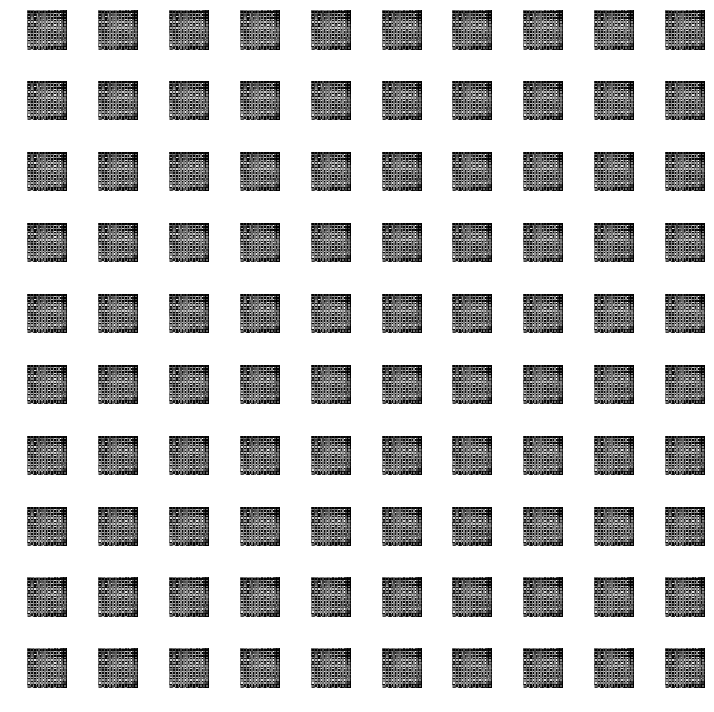

>Saved: generated_plot_0020.png and model_0020.h5
>21, 1/468, dr[0.000,0.308], df[0.000,0.000], g[-16.118,0.000]
>21, 2/468, dr[0.000,0.341], df[0.000,0.000], g[-16.118,0.001]
>21, 3/468, dr[0.000,0.381], df[0.000,0.000], g[-16.118,0.000]
>21, 4/468, dr[0.000,0.469], df[0.000,0.000], g[-16.118,0.001]
>21, 5/468, dr[0.000,0.369], df[0.000,0.000], g[-16.118,0.000]
>21, 6/468, dr[0.000,0.406], df[0.000,0.000], g[-16.118,0.001]
>21, 7/468, dr[0.000,0.332], df[0.000,0.000], g[-16.118,0.000]
>21, 8/468, dr[0.000,0.436], df[0.000,0.000], g[-16.118,0.000]
>21, 9/468, dr[0.000,0.424], df[0.000,0.001], g[-16.118,0.001]
>21, 10/468, dr[0.000,0.286], df[0.000,0.000], g[-16.118,0.000]
>21, 11/468, dr[0.000,0.673], df[0.000,0.000], g[-16.118,0.000]
>21, 12/468, dr[0.000,0.348], df[0.000,0.000], g[-16.118,0.001]
>21, 13/468, dr[0.000,0.325], df[0.000,0.000], g[-16.118,0.000]
>21, 14/468, dr[0.000,0.265], df[0.000,0.003], g[-16.118,0.000]
>21, 15/468, dr[0.000,0.490], df[0.000,0.001], g[-16.118,0.001]

>21, 133/468, dr[0.000,0.379], df[0.000,0.000], g[-16.118,0.001]
>21, 134/468, dr[0.000,0.349], df[0.000,0.001], g[-16.118,0.000]
>21, 135/468, dr[0.000,0.323], df[0.000,0.000], g[-16.118,0.001]
>21, 136/468, dr[0.000,0.371], df[0.000,0.000], g[-16.118,0.003]
>21, 137/468, dr[0.000,0.399], df[0.000,0.001], g[-16.118,0.001]
>21, 138/468, dr[0.000,0.258], df[0.000,0.000], g[-16.118,0.000]
>21, 139/468, dr[0.000,0.509], df[0.000,0.000], g[-16.118,0.001]
>21, 140/468, dr[0.000,0.489], df[0.000,0.001], g[-16.118,0.000]
>21, 141/468, dr[0.000,0.438], df[0.000,0.000], g[-16.118,0.000]
>21, 142/468, dr[0.000,0.333], df[0.000,0.000], g[-16.118,0.001]
>21, 143/468, dr[0.000,0.465], df[0.000,0.001], g[-16.117,0.001]
>21, 144/468, dr[0.000,0.292], df[0.000,0.000], g[-16.118,0.001]
>21, 145/468, dr[0.000,0.316], df[0.000,0.000], g[-16.118,0.000]
>21, 146/468, dr[0.000,0.486], df[0.000,0.001], g[-16.118,0.001]
>21, 147/468, dr[0.000,0.352], df[0.000,0.001], g[-16.118,0.001]
>21, 148/468, dr[0.000,0.

>21, 262/468, dr[0.000,0.497], df[0.000,0.001], g[-16.118,0.001]
>21, 263/468, dr[0.000,0.249], df[0.000,0.000], g[-16.118,0.001]
>21, 264/468, dr[0.000,0.560], df[0.000,0.001], g[-16.118,0.002]
>21, 265/468, dr[0.000,0.522], df[0.000,0.001], g[-16.118,0.001]
>21, 266/468, dr[0.000,0.293], df[0.000,0.001], g[-16.118,0.001]
>21, 267/468, dr[0.000,0.303], df[0.000,0.001], g[-16.118,0.001]
>21, 268/468, dr[0.000,0.563], df[0.000,0.000], g[-16.118,0.000]
>21, 269/468, dr[0.000,0.487], df[0.000,0.000], g[-16.118,0.000]
>21, 270/468, dr[0.000,0.457], df[0.000,0.000], g[-16.118,0.001]
>21, 271/468, dr[0.000,0.426], df[0.000,0.001], g[-16.118,0.000]
>21, 272/468, dr[0.000,0.386], df[0.000,0.000], g[-16.118,0.000]
>21, 273/468, dr[0.000,0.361], df[0.000,0.000], g[-16.118,0.001]
>21, 274/468, dr[0.000,0.598], df[0.000,0.000], g[-16.118,0.000]
>21, 275/468, dr[0.000,0.315], df[0.000,0.001], g[-16.118,0.002]
>21, 276/468, dr[0.000,0.388], df[0.000,0.001], g[-16.118,0.000]
>21, 277/468, dr[0.000,0.

KeyboardInterrupt: 

In [26]:
# train model
fashion_acgan.train(X, y, n_epochs=50, reporting_period=5)

Plot training metrics out

In [29]:
fashion_acgan.plot_training_metrics()

NameError: name 'plt' is not defined

## Evaluation
The AC-GAN technically does not conditionally generate images based on the class label, at least not in the same way as the conditional GAN. Nevertheless, the generated images often match the class label.

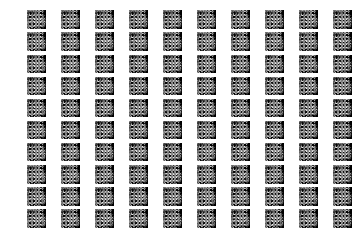

In [32]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

# generate images
latent_points, _ = fashion_acgan.generate_latent_points_conditioned(100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])

# generate images
X = fashion_acgan.generator_prediction_conditioned(latent_points, labels)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
save_plot(X, 10)